# Domestic migration rates

We aim here to generate data files that can be used by the sim to:
- Select *who* moves within the US
- Determine *where* they move
- Determine *what living arrangments* they move into (GQ vs non-GQ, existing vs non-existing household, relationship within household)

We inform all of this with ACS PUMS.

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
from numpy.random import default_rng
import scipy.stats as stats

pd.set_option('display.min_rows', 20)

! whoami
! date

zmbc
Mon Jan  1 11:42:04 AM PST 2024


## Read PUMS and investigate the data

In [2]:
data_dir = '/ihme/scratch/users/zmbc/vivarium_research_prl/migration/data'
acs = pd.read_hdf(f'{data_dir}/acs_2020_5yr_person.hdf', key='acs')

In [3]:
# Duplicate indices! In the future, should probably deal with this in download_acs!
# Filter to relevant columns to save memory
acs = acs[['SERIALNO', 'MIG', 'MIGSP', 'MIGPUMA', 'RELSHIPP', 'HISP', 'RAC1P', 'AGEP', 'SEX', 'ST', 'PUMA', 'PWGTP']].reset_index(drop=True)

### Define demographics and migration

In [4]:
# Based on code from vivarium_census_prl_synth_pop repository:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L105-L118

LATINO_VAR_MAP = {i: (1 if i == 1 else 0) for i in range(1, 25)}

RACE_ETHNICITY_VAR_MAP = {
    0: "Latino",
    1: "White",
    2: "Black",
    3: "AIAN",
    4: "AIAN",
    5: "AIAN",
    6: "Asian",
    7: "NHOPI",
    8: "Multiracial or Other",
    9: "Multiracial or Other",
}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L99-L106

acs["race_ethnicity"] = acs.HISP.map(LATINO_VAR_MAP)
acs.loc[acs.race_ethnicity == 1, "race_ethnicity"] = acs.loc[
    acs.race_ethnicity == 1
].RAC1P

# label each race/eth
acs.race_ethnicity = acs.race_ethnicity.map(RACE_ETHNICITY_VAR_MAP)

In [5]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L120

SEX_VAR_MAP = {1: "Male", 2: "Female"}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L109

acs['sex'] = acs.SEX.map(SEX_VAR_MAP)

In [6]:
acs['age_group'] = pd.cut(acs.AGEP, [0, 15, 18, 19, 20, 21, 22, 25, 30, 40, 50, 60, 70, 80, 100], right=False)

In [7]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/acc34afed6a55484abee0d37452a1cbe10f31b8b/src/vivarium_census_prl_synth_pop/constants/metadata.py#L122-L142
RELATIONSHIP_TO_HOUSEHOLD_HEAD_MAP = {
    20: "Reference person",
    21: "Opp-sex spouse",
    22: "Opp-sex partner",
    23: "Same-sex spouse",
    24: "Same-sex partner",
    25: "Biological child",
    26: "Adopted child",
    27: "Stepchild",
    28: "Sibling",
    29: "Parent",
    30: "Grandchild",
    31: "Parent-in-law",
    32: "Child-in-law",
    33: "Other relative",
    34: "Roommate",
    35: "Foster child",
    36: "Other nonrelative",
    37: "Institutionalized GQ pop",
    38: "Noninstitutionalized GQ pop",
}

acs['relationship'] = acs.RELSHIPP.map(RELATIONSHIP_TO_HOUSEHOLD_HEAD_MAP)

In [8]:
# Migration in the last year is undefined for people < 1 year old.
acs[acs.MIG.isnull()].AGEP.describe()

count    144857.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: AGEP, dtype: float64

In [9]:
# NOTE: We do not include people who moved from Puerto Rico. We don't include them in international immigration either, so these people are effectively missed.
acs['domestic_migrant'] = np.where(acs.MIG.isnull(), np.nan, (acs.MIG == 3) & (acs.MIGSP != 72))
acs['gq_person'] = acs.RELSHIPP.isin([37, 38])
acs['ref_person'] = (acs.RELSHIPP == 20)

In [10]:
# Percent moving domestically
acs[acs.domestic_migrant == 1].PWGTP.sum() / acs[acs.domestic_migrant.notnull()].PWGTP.sum()

0.13215883306519635

### Living arrangement

We separate "living arrangement" into two parts: move type and (optionally) relationship.

Move type is into GQ ("gq_person"), starting a new household ("new_household"), moving with a full household ("household"), and joining an existing household ("non_reference_person").

Specifically, these four operations:
- An entire household of more than one person moves as a unit
- A person moves by themselves into GQ
- A person moves by themselves and establishes a new household
- A person moves by themselves and joins an existing household as a non-reference person

These are **not** the only things that can happen in real life.
We do our best to interpret every existing household in ACS as having been created in the last year by some
combination of these operations, and assign each mover one of the types.
Sometimes, this is unlikely: for example, a small household that moved together is fairly likely to be a newly-established
household, not an existing household that moved as-is from somewhere else.
Also, households with multiple non-reference person movers likely happened by a single subfamily moving, rather than
by individuals moving separately.
In these cases, our explanations are unlikely but not clearly false.

However, there is a case that cannot ever be created by these operations:
a household with a reference person who moved with other household members who did not.
We treat this case as if the non-moving members were not there; in other words, as if the moving
reference person had established that household in the last year, even though we know this cannot
be the case.

For two of these move types, relationship is a non-issue: starting a new household, you are always the reference person;
moving with a full household, your relationship attribute is unchanged.

For the remaining two, there is an additional random step where relationship is assigned.
For GQ person moves this is just institutionalized vs non.
For non-reference person moves, this is one of all the many relationship possibilities.

In [11]:
# How prevalent is the edge case described above, where they are a moving reference person, and they have non-moving non-reference people in their household?
# As a percentage of ref people who moved
acs[
    acs.ref_person & (acs.domestic_migrant == 1) &
        (acs.SERIALNO.isin(acs[(~acs.ref_person) & (acs.domestic_migrant == 0)].SERIALNO.unique()))
].PWGTP.sum() / acs[acs.ref_person & (acs.domestic_migrant == 1)].PWGTP.sum()

0.09998409264914858

In [12]:
impossible_household_examples = acs[
    acs.ref_person & (acs.domestic_migrant == 1) &
        (acs.SERIALNO.isin(acs[(~acs.ref_person) & (acs.domestic_migrant == 0)].SERIALNO.unique()))
].SERIALNO.sample(5, random_state=np.random.RandomState(1234))
acs[acs.SERIALNO.isin(impossible_household_examples)].sort_values(['SERIALNO', 'RELSHIPP'])

SERIALNO  MIG  MIGSP  MIGPUMA  RELSHIPP  HISP  RAC1P  AGEP  \
5045593   2018HU1001792  3.0   35.0   1100.0        20     1      1    28   
5045599   2018HU1001792  1.0    NaN      NaN        22     2      9    43   
5045594   2018HU1001792  3.0   35.0   1100.0        25     2      1     7   
5045595   2018HU1001792  3.0   35.0   1100.0        25     2      1     2   
5045596   2018HU1001792  3.0   35.0   1100.0        25     2      1     1   
5045597   2018HU1001792  NaN    NaN      NaN        25     2      1     0   
5045598   2018HU1001792  NaN    NaN      NaN        25     2      1     0   
9339286   2019HU1086746  3.0   10.0    100.0        20     1      1    56   
9339287   2019HU1086746  1.0    NaN      NaN        21     1      1    63   
3837141   2020HU0228628  3.0   12.0   1100.0        20     1      1    57   
3837142   2020HU0228628  1.0    NaN      NaN        28     1      1    61   
14818552  2020HU0339731  3.0   36.0   4100.0        20     1      1    70   
14818553  2020HU0339731  1.0    NaN      NaN        21     1      1    69   
3457720   2020HU0386823  3.0   53.0  11600.0        20     1      1    21   
3457721   2020HU0386823  3.0   53.0  11600.0        24     1      1    21   
3457722   2020HU0386823  1.0    NaN      NaN        29     1      1    48   

          SEX  ST   PUMA  PWGTP race_ethnicity     sex age_group  \
5045593     2  35   1100      4          White  Female  [25, 30)   
5045599     1  35   1100      9         Latino    Male  [40, 50)   
5045594     1  35   1100      5         Latino    Male   [0, 15)   
5045595     1  35   1100     11         Latino    Male   [0, 15)   
5045596     1  35   1100     11         Latino    Male   [0, 15)   
5045597     1  35   1100     11         Latino    Male   [0, 15)   
5045598     1  35   1100     11         Latino    Male   [0, 15)   
9339286     2  23    500      4          White  Female  [50, 60)   
9339287     1  23    500      4          White    Male  [60, 70)   
3837141     1  55    900     11          White    Male  [50, 60)   
3837142     2  55    900     13          White  Female  [60, 70)   
14818552    1  12   9907     32          White    Male  [70, 80)   
14818553    2  12   9907     33          White  Female  [60, 70)   
3457720     2  53  11602     12          White  Female  [21, 22)   
3457721     2  53  11602     14          White  Female  [21, 22)   
3457722     2  53  11602     17          White  Female  [40, 50)   

              relationship  domestic_migrant  gq_person  ref_person  
5045593   Reference person               1.0      False        True  
5045599    Opp-sex partner               0.0      False       False  
5045594   Biological child               1.0      False       False  
5045595   Biological child               1.0      False       False  
5045596   Biological child               1.0      False       False  
5045597   Biological child               NaN      False       False  
5045598   Biological child               NaN      False       False  
9339286   Reference person               1.0      False        True  
9339287     Opp-sex spouse               0.0      False       False  
3837141   Reference person               1.0      False        True  
3837142            Sibling               0.0      False       False  
14818552  Reference person               1.0      False        True  
14818553    Opp-sex spouse               0.0      False       False  
3457720   Reference person               1.0      False        True  
3457721   Same-sex partner               1.0      False       False  
3457722             Parent               0.0      False       False

In [13]:
# Add column for the MIGPUMA of the reference person, for use in defining move types
acs = acs.merge(acs[(acs.domestic_migrant == 1) & acs.ref_person][['SERIALNO', 'MIGPUMA']], on='SERIALNO', suffixes=(None, '_ref_person'), how='left')

In [14]:
acs['move_type'] = np.where(
    acs.domestic_migrant == 1,
    np.where(
        acs.gq_person,
        'gq_person',
        np.where(
            # They founded a new household if:
            # - They are the reference person, AND
            # - Nobody else in the household moved with them (from same MIGPUMA) -- including if they were the only mover in the household
            acs.ref_person & acs.SERIALNO.isin(acs[acs.MIGPUMA_ref_person == acs.MIGPUMA].groupby('SERIALNO').size().pipe(lambda x: x[x == 1]).index),
            'new_household',
            # Where the reference person moved from same MIGPUMA, we assume they were part of a household move
            # This happens both if they *are* the reference person (with other people who moved with them),
            # or if they are a non-reference person who moved along with the reference person.
            np.where(acs.MIGPUMA_ref_person == acs.MIGPUMA, 'household', 'non_reference_person'),
        ),
    ),
    np.where(
        acs.domestic_migrant == 0,
        'none',
        # Can't make this np.nan because it is a string type
        # FIXME: This should really be excluded from denominators as well as numerators --
        # by not doing this we are currently assuming people < 1 year old never move.
        'undefined',
    )
)

In [15]:
assert (acs[acs.move_type == 'undefined'].AGEP == 0).all()

In [16]:
# Move type distribution (this should not be interpreted as the *number* of moves because household moves affect multiple people each)
acs[acs.domestic_migrant == 1].groupby('move_type').PWGTP.sum() / acs[acs.domestic_migrant == 1].PWGTP.sum()

move_type
gq_person               0.083051
household               0.585842
new_household           0.151385
non_reference_person    0.179722
Name: PWGTP, dtype: float64

## Inputs for automated V&V

We do not do *pure* verification in the automated V&V of domestic migration -- that is, we do not test exactly the values that we feed into the simulation.
This is because the rates that we feed in are highly stratified, such that a very large
sample size would be needed to verify them, and a very large number of rates would need to be verified.

Instead, we check the rates at the population level, which is part verification and part validation.
In theory, it checks that the rates are correct (as a whole) and that the population structure in our simulation
matches the population structure of the ACS data.
Of course, these things could both be wrong in a way that cancels out, in which case our tests would not find the issue.

This is nearly purely verification at the first timestep when our population has just been sampled from ACS -- the only slight
mismatch between the sim inputs and the V&V input is that the former has had some missingness filled in with median rates.
Over the timesteps, it becomes more and more a validation that the dynamics in our simulation form a roughly steady state for the population structure.

In [17]:
# Individual migration rates (denominator = ACS persons)
individual_migration_rate_per_year = acs[acs.move_type.isin(['new_household', 'gq_person', 'non_reference_person'])].groupby('move_type').PWGTP.sum() / acs.PWGTP.sum()
individual_migration_rate_per_year

move_type
gq_person               0.010855
new_household           0.019786
non_reference_person    0.023489
Name: PWGTP, dtype: float64

In [18]:
# Household migration rate (using reference people, which is equivalent to households / households)
household_migration_rate_per_year = acs[(acs.ref_person == 1) & (acs.move_type == 'household')].PWGTP.sum() / acs[acs.ref_person == 1].PWGTP.sum()
household_migration_rate_per_year

0.06865104510078264

In [19]:
v_and_v_inputs = {
    'household_migration_rate_per_year': float(household_migration_rate_per_year),
    'individual_migration_rate_per_year': {k: float(v) for k, v in individual_migration_rate_per_year.items()},
    # As noted above, this starts out as (essentially) pure verification, but becomes more
    # of a validation over time as the population structure may change.
    # We quantify our beliefs about this as a multiplicative drift factor: for each year
    # of population dynamics applied, what range of multiplicative factors
    # could plausibly be applied to (each of) the migration rate(s)?
    # These are not based on any data, just a sort of intuition that population
    # structure could change things non-trivially but not massively.
    'multiplicative_drift_per_year': {
        'lower_bound': 0.90,
        'upper_bound': 1.10,
    },
}
v_and_v_inputs

{'household_migration_rate_per_year': 0.06865104510078264,
 'individual_migration_rate_per_year': {'gq_person': 0.010854666688840622,
  'new_household': 0.01978582439294686,
  'non_reference_person': 0.02348931693394372},
 'multiplicative_drift_per_year': {'lower_bound': 0.9, 'upper_bound': 1.1}}

In [20]:
import yaml
with open('v_and_v_inputs/domestic_migration.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(v_and_v_inputs, f, default_flow_style=False)

## Rates of move types by demographics

In [21]:
def add_age_bounds(df):
    df = df.copy()
    age_bound_cols = ['age_start', 'age_end']
    df[['age_start', 'age_end']] = [[x.left, x.right] for x in df['age_group']]
    
    return df[age_bound_cols + [c for c in df.columns if c not in age_bound_cols]].copy()

In [22]:
def add_age_midpoint(df):
    if 'age_start' not in df.columns or 'age_end' not in df.columns:
        df = add_age_bounds(df)
    df['age_midpoint'] = np.average(df[['age_start', 'age_end']], axis=1)
    
    return df

In [23]:
def display_migration_rates(migration_rates, name):
    migration_rates = add_age_midpoint(migration_rates.rename(name).reset_index())
    
    sns.relplot(
        data=migration_rates,
        x="age_midpoint", y=name,
        hue="race_ethnicity",
        col="sex",
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )

In [24]:
def format_migration_rates_for_file(migration_rates, name):
    migration_rates = add_age_bounds(migration_rates.rename(name).reset_index())
    migration_rates = migration_rates.drop(columns=['age_group']).rename(columns={'ST': 'state', 'PUMA': 'puma'})
    return migration_rates

In [25]:
def display_sample_size(acs_df, move_type, stratification_columns=['age_group', 'sex', 'race_ethnicity'], col_suffix=''):
    acs_subset = acs_df[(acs_df.domestic_migrant == 1) & (acs_df.move_type == move_type)]
    sample_size = acs_subset.groupby([col + col_suffix for col in stratification_columns]).size().rename('sample_size').reset_index()
    sample_size = add_age_midpoint(sample_size)

    g = sns.relplot(
        data=sample_size,
        x="age_midpoint", y="sample_size",
        hue="race_ethnicity" + col_suffix,
        col="sex" + col_suffix,
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )
    g.set(yscale="symlog")
    g.set(ylim=(0, None))
    return g

In [26]:
def format_migration_rates_for_file(migration_rates, name):
    if isinstance(migration_rates, pd.Series):
        migration_rates = migration_rates.rename(name).reset_index()
    else:
        migration_rates = migration_rates.reset_index()

    migration_rates = add_age_bounds(migration_rates).drop(columns=['age_group']).rename(columns={'ST': 'state', 'PUMA': 'puma'})
    return migration_rates

### Household moves

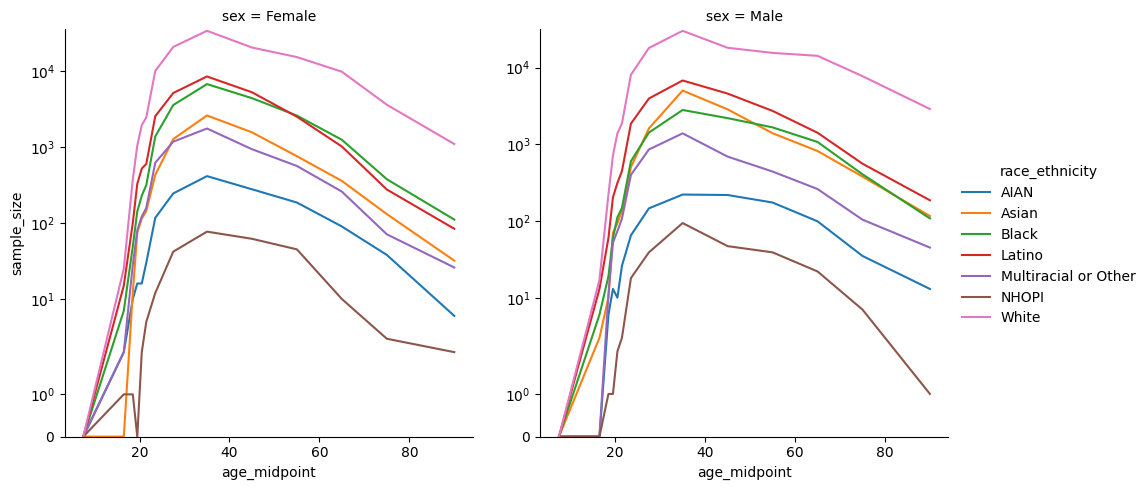

In [27]:
display_sample_size(acs[acs.ref_person], 'household')

In [28]:
hh_move_rates = (
    acs[acs.ref_person & (acs.move_type == 'household')].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum() /
        # NOTE: Population at risk is households with >1 person in them!
        acs[(acs.ref_person) & (acs.SERIALNO.isin(acs.groupby('SERIALNO').size().pipe(lambda x: x[x > 1]).index))].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum()
)
hh_move_rates

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                         NaN
                   Asian                        NaN
                   Black                        NaN
                   Latino                       NaN
                   Multiracial or Other         NaN
                   NHOPI                        NaN
                   White                        NaN
           Male    AIAN                         NaN
                   Asian                        NaN
                   Black                        NaN
                                             ...   
[80, 100)  Female  Multiracial or Other    0.026681
                   NHOPI                   0.010601
                   White                   0.024590
           Male    AIAN                    0.016338
                   Asian                   0.030044
                   Black                   0.016109
                   Latino                  0.025954
                   Multi

In [29]:
len(hh_move_rates[hh_move_rates.isnull()])

14

In [30]:
len(hh_move_rates[hh_move_rates == np.inf])

0

In [31]:
len(hh_move_rates[hh_move_rates == 0])

5

In [32]:
hh_move_rates = hh_move_rates.replace(np.inf, np.nan).fillna(hh_move_rates.median())
hh_move_rates.sort_values()

age_group  sex     race_ethnicity      
[15, 18)   Male    AIAN                    0.000000
[19, 20)   Female  NHOPI                   0.000000
[15, 18)   Female  Asian                   0.000000
           Male    NHOPI                   0.000000
                   Multiracial or Other    0.000000
[80, 100)  Female  NHOPI                   0.010601
                   AIAN                    0.012650
                   Latino                  0.014463
[70, 80)   Female  NHOPI                   0.015147
[80, 100)  Female  Black                   0.015185
                                             ...   
[19, 20)   Female  White                   0.439462
           Male    Multiracial or Other    0.440199
[18, 19)   Female  White                   0.445785
[19, 20)   Female  Multiracial or Other    0.449700
[18, 19)   Female  Multiracial or Other    0.516464
           Male    AIAN                    0.539652
           Female  AIAN                    0.628049
           Male    NHOPI

In [33]:
assert (
    len(hh_move_rates) ==
        hh_move_rates.index.get_level_values('age_group').nunique() * hh_move_rates.index.get_level_values('sex').nunique() * hh_move_rates.index.get_level_values('race_ethnicity').nunique()
)

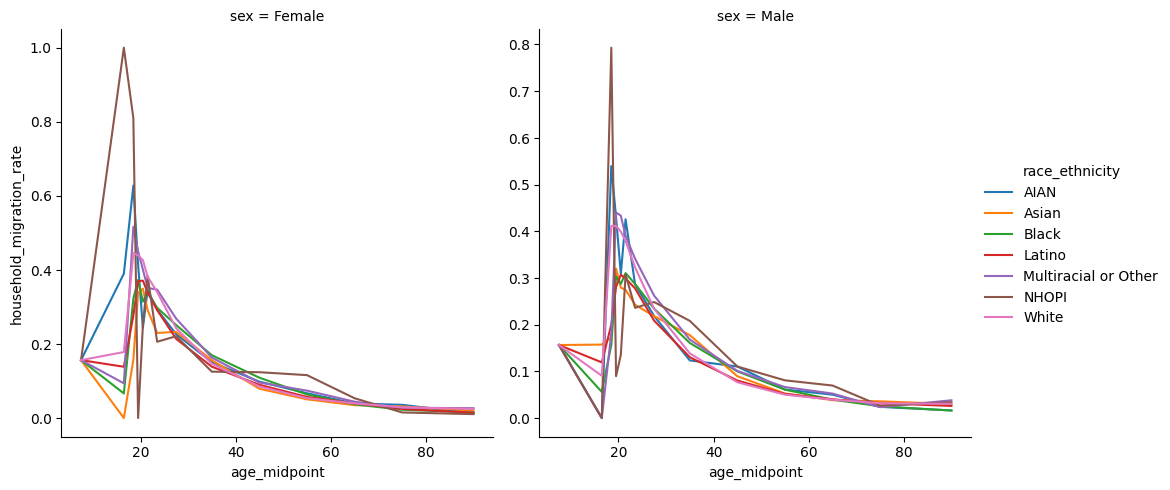

In [34]:
display_migration_rates(hh_move_rates, 'household_migration_rate')

In [35]:
format_migration_rates_for_file(hh_move_rates, 'household_domestic_migration_rate').to_csv('sim_inputs/household_domestic_migration_rates.csv', index=False, float_format='%f')

### Person-level rates
#### GQ person

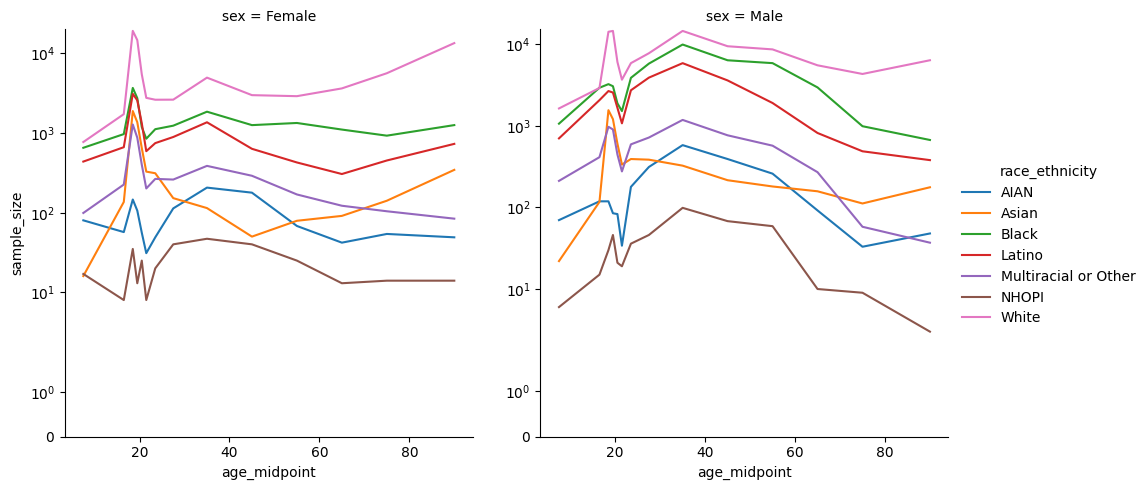

In [36]:
display_sample_size(acs, 'gq_person')

In [37]:
gq_person_migration_rates = (
    acs[acs.move_type == 'gq_person'].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum() /
        acs.groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum()
)
gq_person_migration_rates

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                    0.002394
                   Asian                   0.000074
                   Black                   0.001307
                   Latino                  0.000381
                   Multiracial or Other    0.000471
                   NHOPI                   0.002340
                   White                   0.000340
           Male    AIAN                    0.002209
                   Asian                   0.000035
                   Black                   0.001867
                                             ...   
[80, 100)  Female  Multiracial or Other    0.008364
                   NHOPI                   0.015128
                   White                   0.020082
           Male    AIAN                    0.022176
                   Asian                   0.007225
                   Black                   0.019369
                   Latino                  0.008555
                   Multi

In [38]:
len(gq_person_migration_rates[gq_person_migration_rates.isnull()])

0

In [39]:
len(gq_person_migration_rates[gq_person_migration_rates == np.inf])

0

In [40]:
len(gq_person_migration_rates[gq_person_migration_rates == 0])

0

In [41]:
gq_person_migration_rates = gq_person_migration_rates.replace(np.inf, np.nan).fillna(gq_person_migration_rates.median())
gq_person_migration_rates.sort_values()

age_group  sex     race_ethnicity      
[0, 15)    Male    Asian                   0.000035
           Female  Asian                   0.000074
                   White                   0.000340
                   Latino                  0.000381
[40, 50)   Female  Asian                   0.000383
[0, 15)    Female  Multiracial or Other    0.000471
           Male    Latino                  0.000607
                   White                   0.000672
[60, 70)   Female  Asian                   0.000688
[0, 15)    Male    NHOPI                   0.000693
                                             ...   
[19, 20)   Male    Asian                   0.132777
[18, 19)   Female  Black                   0.135829
           Male    White                   0.145517
           Female  Multiracial or Other    0.149349
[19, 20)   Female  Asian                   0.152900
           Male    White                   0.159538
           Female  White                   0.161300
[18, 19)   Male    Asian

In [42]:
assert (
    len(gq_person_migration_rates) ==
        gq_person_migration_rates.index.get_level_values('age_group').nunique() * gq_person_migration_rates.index.get_level_values('sex').nunique() * gq_person_migration_rates.index.get_level_values('race_ethnicity').nunique()
)

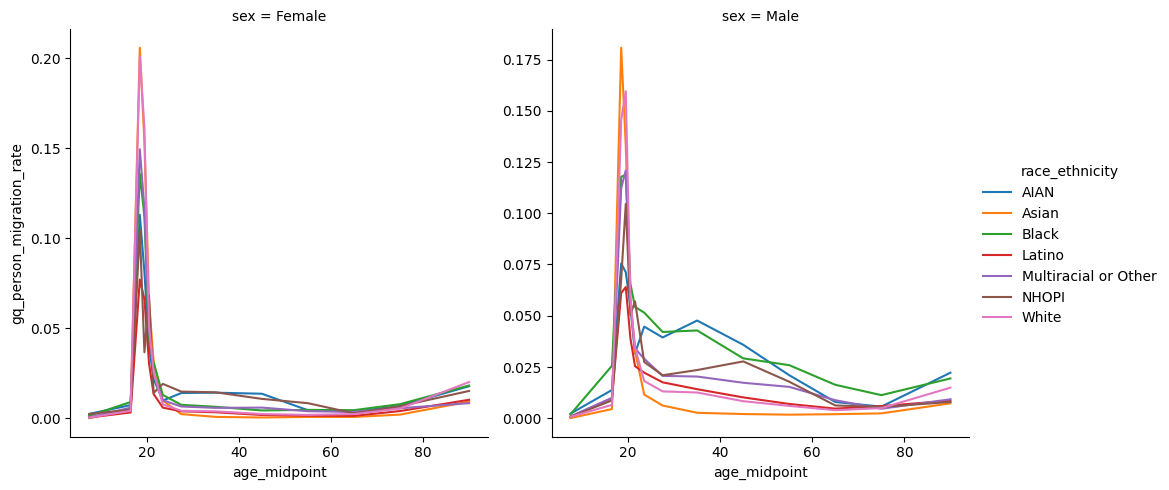

In [43]:
display_migration_rates(gq_person_migration_rates, 'gq_person_migration_rate')

In [44]:
format_migration_rates_for_file(gq_person_migration_rates, 'gq_person_migration_rate')

age_start  age_end     sex        race_ethnicity  \
0            0       15  Female                  AIAN   
1            0       15  Female                 Asian   
2            0       15  Female                 Black   
3            0       15  Female                Latino   
4            0       15  Female  Multiracial or Other   
5            0       15  Female                 NHOPI   
6            0       15  Female                 White   
7            0       15    Male                  AIAN   
8            0       15    Male                 Asian   
9            0       15    Male                 Black   
..         ...      ...     ...                   ...   
186         80      100  Female  Multiracial or Other   
187         80      100  Female                 NHOPI   
188         80      100  Female                 White   
189         80      100    Male                  AIAN   
190         80      100    Male                 Asian   
191         80      100    Male                 Black   
192         80      100    Male                Latino   
193         80      100    Male  Multiracial or Other   
194         80      100    Male                 NHOPI   
195         80      100    Male                 White   

     gq_person_migration_rate  
0                    0.002394  
1                    0.000074  
2                    0.001307  
3                    0.000381  
4                    0.000471  
5                    0.002340  
6                    0.000340  
7                    0.002209  
8                    0.000035  
9                    0.001867  
..                        ...  
186                  0.008364  
187                  0.015128  
188                  0.020082  
189                  0.022176  
190                  0.007225  
191                  0.019369  
192                  0.008555  
193                  0.009203  
194                  0.007874  
195                  0.014874  

[196 rows x 5 columns]

#### New household

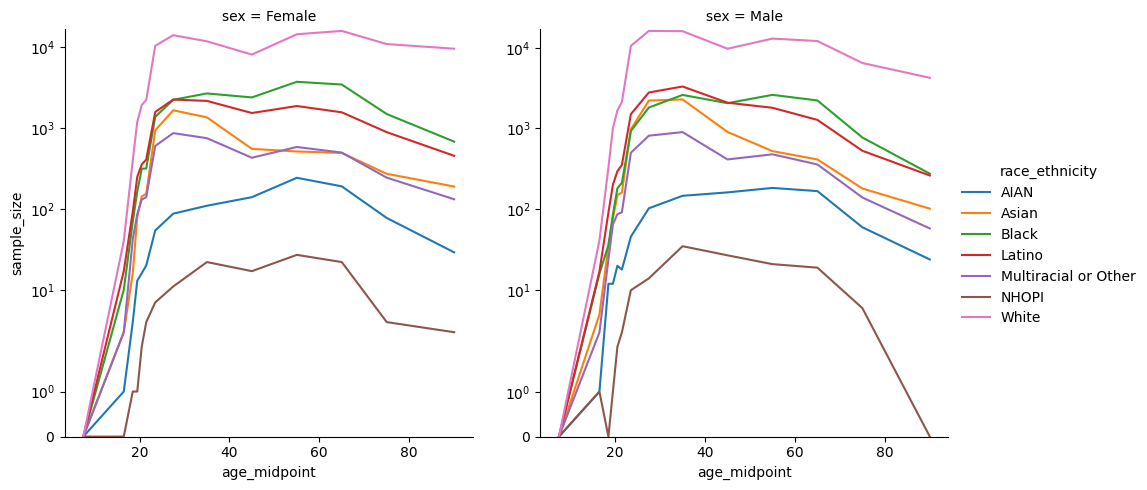

In [45]:
display_sample_size(acs, 'new_household')

In [46]:
new_household_migration_rates = (
    acs[acs.move_type == 'new_household'].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum() /
        acs.groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum()
)
new_household_migration_rates

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                    0.000000
                   Asian                   0.000000
                   Black                   0.000000
                   Latino                  0.000000
                   Multiracial or Other    0.000000
                   NHOPI                   0.000000
                   White                   0.000000
           Male    AIAN                    0.000000
                   Asian                   0.000000
                   Black                   0.000000
                                             ...   
[80, 100)  Female  Multiracial or Other    0.034615
                   NHOPI                   0.006082
                   White                   0.032790
           Male    AIAN                    0.022119
                   Asian                   0.012188
                   Black                   0.016119
                   Latino                  0.014895
                   Multi

In [47]:
len(new_household_migration_rates[new_household_migration_rates.isnull()])

0

In [48]:
len(new_household_migration_rates[new_household_migration_rates == np.inf])

0

In [49]:
len(new_household_migration_rates[new_household_migration_rates == 0])

17

In [50]:
new_household_migration_rates = new_household_migration_rates.replace(np.inf, np.nan).fillna(new_household_migration_rates.median())
new_household_migration_rates.sort_values()

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                    0.000000
[80, 100)  Male    NHOPI                   0.000000
[15, 18)   Female  NHOPI                   0.000000
[0, 15)    Male    White                   0.000000
                   NHOPI                   0.000000
                   Multiracial or Other    0.000000
                   Latino                  0.000000
                   Black                   0.000000
[18, 19)   Male    NHOPI                   0.000000
[0, 15)    Male    AIAN                    0.000000
                                             ...   
[22, 25)   Male    Multiracial or Other    0.058435
[25, 30)   Female  Multiracial or Other    0.058604
           Male    White                   0.059463
[22, 25)   Female  Asian                   0.060213
           Male    Asian                   0.063069
[25, 30)   Male    Multiracial or Other    0.064363
[22, 25)   Female  Multiracial or Other    0.066200
           Male    White

In [51]:
assert (
    len(new_household_migration_rates) ==
        new_household_migration_rates.index.get_level_values('age_group').nunique() * new_household_migration_rates.index.get_level_values('sex').nunique() * new_household_migration_rates.index.get_level_values('race_ethnicity').nunique()
)

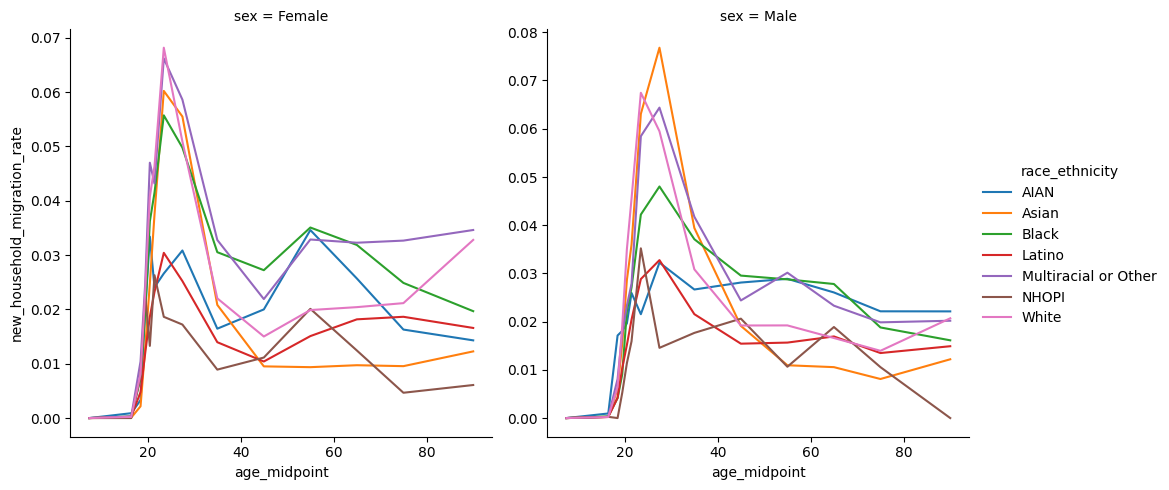

In [52]:
display_migration_rates(new_household_migration_rates, 'new_household_migration_rate')

In [53]:
format_migration_rates_for_file(new_household_migration_rates, 'new_household_migration_rate')

age_start  age_end     sex        race_ethnicity  \
0            0       15  Female                  AIAN   
1            0       15  Female                 Asian   
2            0       15  Female                 Black   
3            0       15  Female                Latino   
4            0       15  Female  Multiracial or Other   
5            0       15  Female                 NHOPI   
6            0       15  Female                 White   
7            0       15    Male                  AIAN   
8            0       15    Male                 Asian   
9            0       15    Male                 Black   
..         ...      ...     ...                   ...   
186         80      100  Female  Multiracial or Other   
187         80      100  Female                 NHOPI   
188         80      100  Female                 White   
189         80      100    Male                  AIAN   
190         80      100    Male                 Asian   
191         80      100    Male                 Black   
192         80      100    Male                Latino   
193         80      100    Male  Multiracial or Other   
194         80      100    Male                 NHOPI   
195         80      100    Male                 White   

     new_household_migration_rate  
0                        0.000000  
1                        0.000000  
2                        0.000000  
3                        0.000000  
4                        0.000000  
5                        0.000000  
6                        0.000000  
7                        0.000000  
8                        0.000000  
9                        0.000000  
..                            ...  
186                      0.034615  
187                      0.006082  
188                      0.032790  
189                      0.022119  
190                      0.012188  
191                      0.016119  
192                      0.014895  
193                      0.020180  
194                      0.000000  
195                      0.020685  

[196 rows x 5 columns]

#### Non-reference person

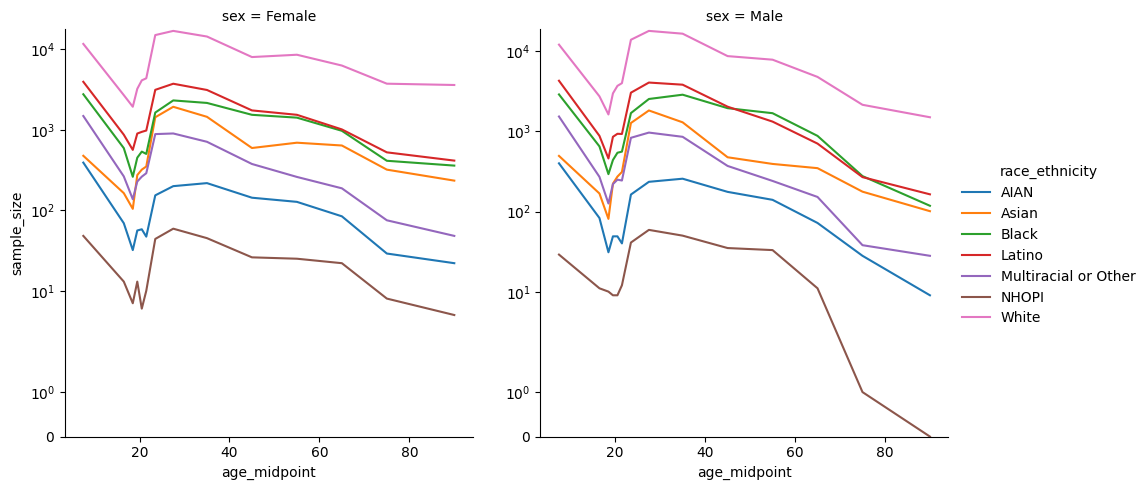

In [54]:
display_sample_size(acs, 'non_reference_person')

In [55]:
non_reference_person_migration_rates = (
    acs[acs.move_type == 'non_reference_person'].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum() /
        acs.groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum()
)
non_reference_person_migration_rates

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                    0.025418
                   Asian                   0.007254
                   Black                   0.019006
                   Latino                  0.012993
                   Multiracial or Other    0.019056
                   NHOPI                   0.014801
                   White                   0.015810
           Male    AIAN                    0.023948
                   Asian                   0.007798
                   Black                   0.019687
                                             ...   
[80, 100)  Female  Multiracial or Other    0.015190
                   NHOPI                   0.020898
                   White                   0.011476
           Male    AIAN                    0.008467
                   Asian                   0.012989
                   Black                   0.008201
                   Latino                  0.012047
                   Multi

In [56]:
len(non_reference_person_migration_rates[non_reference_person_migration_rates.isnull()])

0

In [57]:
len(non_reference_person_migration_rates[non_reference_person_migration_rates == np.inf])

0

In [58]:
len(non_reference_person_migration_rates[non_reference_person_migration_rates == 0])

1

In [59]:
non_reference_person_migration_rates = non_reference_person_migration_rates.replace(np.inf, np.nan).fillna(non_reference_person_migration_rates.median())
non_reference_person_migration_rates.sort_values()

age_group  sex     race_ethnicity      
[80, 100)  Male    NHOPI                   0.000000
[70, 80)   Male    NHOPI                   0.001693
                   White                   0.005050
                   AIAN                    0.005717
                   Multiracial or Other    0.007234
[0, 15)    Female  Asian                   0.007254
[80, 100)  Male    White                   0.007289
[60, 70)   Male    White                   0.007326
[70, 80)   Female  White                   0.007509
                   Black                   0.007745
                                             ...   
[21, 22)   Female  Multiracial or Other    0.091332
[20, 21)   Female  White                   0.091466
[22, 25)   Male    NHOPI                   0.092706
[20, 21)   Female  Multiracial or Other    0.093170
[22, 25)   Male    White                   0.094790
[21, 22)   Female  White                   0.095959
[22, 25)   Female  Multiracial or Other    0.096415
           Male    Multi

In [60]:
assert (
    len(non_reference_person_migration_rates) ==
        non_reference_person_migration_rates.index.get_level_values('age_group').nunique() * non_reference_person_migration_rates.index.get_level_values('sex').nunique() * non_reference_person_migration_rates.index.get_level_values('race_ethnicity').nunique()
)

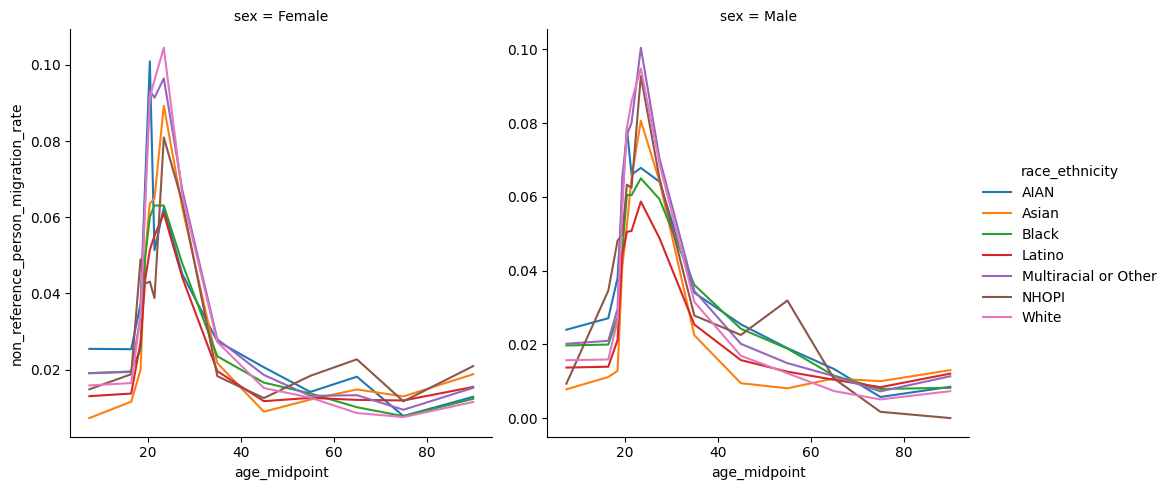

In [61]:
display_migration_rates(non_reference_person_migration_rates, 'non_reference_person_migration_rate')

In [62]:
format_migration_rates_for_file(non_reference_person_migration_rates, 'non_reference_person_migration_rate')

age_start  age_end     sex        race_ethnicity  \
0            0       15  Female                  AIAN   
1            0       15  Female                 Asian   
2            0       15  Female                 Black   
3            0       15  Female                Latino   
4            0       15  Female  Multiracial or Other   
5            0       15  Female                 NHOPI   
6            0       15  Female                 White   
7            0       15    Male                  AIAN   
8            0       15    Male                 Asian   
9            0       15    Male                 Black   
..         ...      ...     ...                   ...   
186         80      100  Female  Multiracial or Other   
187         80      100  Female                 NHOPI   
188         80      100  Female                 White   
189         80      100    Male                  AIAN   
190         80      100    Male                 Asian   
191         80      100    Male                 Black   
192         80      100    Male                Latino   
193         80      100    Male  Multiracial or Other   
194         80      100    Male                 NHOPI   
195         80      100    Male                 White   

     non_reference_person_migration_rate  
0                               0.025418  
1                               0.007254  
2                               0.019006  
3                               0.012993  
4                               0.019056  
5                               0.014801  
6                               0.015810  
7                               0.023948  
8                               0.007798  
9                               0.019687  
..                                   ...  
186                             0.015190  
187                             0.020898  
188                             0.011476  
189                             0.008467  
190                             0.012989  
191                             0.008201  
192                             0.012047  
193                             0.011335  
194                             0.000000  
195                             0.007289  

[196 rows x 5 columns]

In [63]:
rates_for_file = pd.DataFrame(gq_person_migration_rates.rename('gq_person_migration_rate'))\
    .join(new_household_migration_rates.rename('new_household_migration_rate'))\
    .join(non_reference_person_migration_rates.rename('non_reference_person_migration_rate'))\
    .pipe(lambda x: format_migration_rates_for_file(x, None))
rates_for_file.to_csv('sim_inputs/individual_domestic_migration_rates.csv', index=False, float_format='%f')
rates_for_file

age_start  age_end     sex        race_ethnicity  \
0            0       15  Female                  AIAN   
1            0       15  Female                 Asian   
2            0       15  Female                 Black   
3            0       15  Female                Latino   
4            0       15  Female  Multiracial or Other   
5            0       15  Female                 NHOPI   
6            0       15  Female                 White   
7            0       15    Male                  AIAN   
8            0       15    Male                 Asian   
9            0       15    Male                 Black   
..         ...      ...     ...                   ...   
186         80      100  Female  Multiracial or Other   
187         80      100  Female                 NHOPI   
188         80      100  Female                 White   
189         80      100    Male                  AIAN   
190         80      100    Male                 Asian   
191         80      100    Male                 Black   
192         80      100    Male                Latino   
193         80      100    Male  Multiracial or Other   
194         80      100    Male                 NHOPI   
195         80      100    Male                 White   

     gq_person_migration_rate  new_household_migration_rate  \
0                    0.002394                      0.000000   
1                    0.000074                      0.000000   
2                    0.001307                      0.000000   
3                    0.000381                      0.000000   
4                    0.000471                      0.000000   
5                    0.002340                      0.000000   
6                    0.000340                      0.000000   
7                    0.002209                      0.000000   
8                    0.000035                      0.000000   
9                    0.001867                      0.000000   
..                        ...                           ...   
186                  0.008364                      0.034615   
187                  0.015128                      0.006082   
188                  0.020082                      0.032790   
189                  0.022176                      0.022119   
190                  0.007225                      0.012188   
191                  0.019369                      0.016119   
192                  0.008555                      0.014895   
193                  0.009203                      0.020180   
194                  0.007874                      0.000000   
195                  0.014874                      0.020685   

     non_reference_person_migration_rate  
0                               0.025418  
1                               0.007254  
2                               0.019006  
3                               0.012993  
4                               0.019056  
5                               0.014801  
6                               0.015810  
7                               0.023948  
8                               0.007798  
9                               0.019687  
..                                   ...  
186                             0.015190  
187                             0.020898  
188                             0.011476  
189                             0.008467  
190                             0.012989  
191                             0.008201  
192                             0.012047  
193                             0.011335  
194                             0.000000  
195                             0.007289  

[196 rows x 7 columns]

## Relationship, for applicable move types

In [64]:
# Copied from VEHSS, where I did a lot of the same thinking about expanding indices
# https://github.com/ihmeuw/vehss/blob/8f5db275393f8ff9906010a9214e10f4aec71a2b/vehss/utils.py#L119

def merge(df1, df2, on, *args, **kwargs):
    """
    Like df1.merge(df2, on=on, *args, **kwargs), except:
    1. If on is empty, all rows are considered to match (a Cartesian product).
    """
    if len(on) > 0:
        return df1.merge(df2, on=on, *args, **kwargs)

    # Apparently the best way to do this in Pandas
    # https://stackoverflow.com/a/46895905/
    df1 = df1.copy()
    df2 = df2.copy()
    df1['key'] = 0
    df2['key'] = 0
    return df1.merge(df2, on='key', *args, **kwargs).drop(columns=['key'])

def diff_dfs(df1, df2):
    """
    Returns rows not in common between two DataFrames.
    """
    assert len(df1) == len(df1.drop_duplicates())
    assert len(df2) == len(df2.drop_duplicates())
    return pd.concat([df1, df2]).drop_duplicates(keep=False)

def expand_index_to(df, index, any_match=True, full_match=True):
    """
    Changes a df to have a specified index, assuming that the df's index already contains
    some of the index's levels, by duplicating the rows that match on the subset it already
    contains.
    If full_match is True, the desired index must include everything already in the index.
    """
    # First, do some checks
    # Current and desired index have at least one column in common
    common_columns = [c for c in df.index.names if c in index.names]
    if any_match:
        assert len(common_columns) > 0
    if full_match:
        assert len(common_columns) == len(df.index.names)
    # Current and desired index are both unique and have all the same
    # values in the overlapping columns
    assert np.all(~df.index.duplicated())
    assert np.all(~index.duplicated())
    index_as_df = index.to_frame(index=False)
    df_index_as_df = df.index.to_frame(index=False)
    if any_match:
        assert len(diff_dfs(index_as_df[common_columns].drop_duplicates(), df_index_as_df[common_columns].drop_duplicates())) == 0

    return merge(index_as_df, df.reset_index(), on=common_columns, validate='m:1' if full_match else 'm:m')\
        .set_index(index.names)

In [65]:
# Starting here, code is not from VEHSS
def all_combos_of_column_sets(df, column_sets):
    # "Column sets" are lists of lists. The sublists contain column names.
    # The key difference between a column set and a simple list of columns is that the columns
    # that are grouped together in a sublist are assumed to have a hierarchical relationship, and
    # are not expanded to every combination of those columns.
    dfs_of_unique = [df[c].drop_duplicates().sort_values(c) for c in column_sets]
    if len(dfs_of_unique) == 0:
        frame = pd.DataFrame()
    else:
        frame = dfs_of_unique[0]
        for unique_vals in dfs_of_unique[1:]:
            frame = frame.merge(unique_vals, how='cross')

    return pd.MultiIndex.from_frame(frame)

In [66]:
def proportions_by_columns(acs_subset, stratification_columns, proportion_columns, full_index):
    return (
        acs_subset.groupby(stratification_columns + proportion_columns, observed=True).PWGTP.sum().reindex(full_index, fill_value=0) /
            acs_subset.groupby(stratification_columns, observed=True).PWGTP.sum()
    )

In [67]:
def stratification_display_string(stratification_columns):
    stratification_columns_to_print = [c for c in stratification_columns if c != 'dummy_column']
    if len(stratification_columns_to_print) == 0:
        return "the unconditional distribution"
    return "/".join(stratification_columns_to_print)

In [68]:
def filter_nested_list(nested_list, elements_to_allow):
    """
    Filter nested_list (a list of lists) to only include elements in elements_to_allow.
    If a sublist contains no allowed elements, it is omitted entirely.
    """
    filtered = [[c for c in sublist if c in elements_to_allow] for sublist in nested_list]
    return [sublist for sublist in filtered if len(sublist) > 0]

In [69]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

def fill_proportions_by_sample_size(acs_subset, stratification_columns, proportion_columns, min_stratification_columns=0, min_distributed=0.05, sample_size_threshold=30, stratification_column_sets=None, proportion_column_sets=None):
    # "Column sets" are lists of lists. The sublists contain column names.
    # The key difference between a column set and a simple list of columns is that the columns
    # that are grouped together in a sublist are assumed to have a hierarchical relationship, and
    # are not expanded to every combination of those columns.
    if stratification_column_sets is None:
        stratification_column_sets = [[c] for c in stratification_columns]

    if proportion_column_sets is None:
        proportion_column_sets = [[c] for c in proportion_columns]
    
    if min_stratification_columns == 0:
        # We have to special case this because it isn't possible to groupby 0 columns, nor have a Pandas MultiIndex with 0 levels.
        # We add a dummy column with only one value and treat that as a stratification column.
        # Grouping by this dummy column alone represents using the full unconditional distribution.
        added_dummy_column = True
        acs_subset = acs_subset.assign(dummy_column=1)
        stratification_columns = ['dummy_column'] + stratification_columns
        stratification_column_sets = [['dummy_column']] + stratification_column_sets
        min_stratification_columns = 1
    else:
        added_dummy_column = False

    full_index_with_proportion = all_combos_of_column_sets(acs_subset, stratification_column_sets + proportion_column_sets)
    display(Markdown(f'### Smoothing {len(full_index_with_proportion):,} {stratification_display_string(stratification_columns + proportion_columns)} strata'))

    full_index = all_combos_of_column_sets(acs_subset, stratification_column_sets)

    working_sample_size = acs_subset.groupby(stratification_columns + proportion_columns, observed=True).size().reindex(full_index_with_proportion, fill_value=0)
    display(Markdown('Sample size by stratum:'))
    display(pd.DataFrame(working_sample_size))
    working_sample_size.plot(kind='hist', bins=10, title='Sample size by strata', log=True)
    plt.show()
    working_proportions = proportions_by_columns(acs_subset, stratification_columns, proportion_columns, full_index=full_index_with_proportion)

    for stratifications_to_remove in range(1, len(stratification_columns) + 1):
        less_stratification_columns = stratification_columns[:-stratifications_to_remove]

        if len(less_stratification_columns) < min_stratification_columns:
            display(Markdown('Reached minimum desired stratification.'))
            break

        display(Markdown(f'#### Using {stratification_display_string(less_stratification_columns)} reference group(s)'))

        display(Markdown(f'{(working_sample_size >= sample_size_threshold).sum():,} strata already have n >= {sample_size_threshold}.'))
        if np.all(working_sample_size >= sample_size_threshold):
            display(Markdown('No more smoothing required.'))
            break

        display(Markdown(f'Strata with n < {sample_size_threshold}:'))
        display(pd.DataFrame(working_sample_size[working_sample_size < sample_size_threshold]))

        less_stratification_column_sets = filter_nested_list(stratification_column_sets, less_stratification_columns)
        less_stratified_index_with_proportion = all_combos_of_column_sets(acs_subset, less_stratification_column_sets + proportion_column_sets)
        less_stratified_index = all_combos_of_column_sets(acs_subset, less_stratification_column_sets)
        reference_group_distributions = proportions_by_columns(acs_subset, less_stratification_columns, proportion_columns, full_index=less_stratified_index_with_proportion)
        assert np.all(reference_group_distributions.groupby(less_stratification_columns, observed=True).sum() == 1)

        distribute_by = expand_index_to(reference_group_distributions, full_index_with_proportion).PWGTP.sort_index()
        assert np.all(distribute_by.groupby(stratification_columns, observed=True).sum() == 1)
        
        redistribute_among_small_n = 1 - working_proportions[working_sample_size >= sample_size_threshold].groupby(stratification_columns, observed=True).sum().reindex(full_index, fill_value=0)
        display(Markdown('**Step 1:** Redistributing among small-sample-size relationships.'))
        redistribute_among_small_n.plot(kind='hist', bins=10, title='Amount redistributed among small-sample-size relationships', log=True)
        plt.show()

        small_n_distributions = distribute_by.where(working_sample_size < sample_size_threshold, 0)
        small_n_fill_values = small_n_distributions * redistribute_among_small_n / small_n_distributions.groupby(stratification_columns, observed=True).sum().replace(0, 1)
        assert np.allclose(small_n_fill_values.groupby(stratification_columns, observed=True).sum(), redistribute_among_small_n)
        
        working_proportions = working_proportions.where(working_sample_size >= sample_size_threshold, small_n_fill_values)
        assert np.allclose(working_proportions.groupby(stratification_columns, observed=True).sum(), 1)
        assert np.all(working_proportions.notnull())

        redistribute_among_all = (min_distributed - redistribute_among_small_n).clip(lower=0)
        display(Markdown('**Step 2:** Redistributing among all relationships.'))
        if np.all(redistribute_among_all == 0):
            display(Markdown(f'No redistribution required in this step -- all groups already redistributed at least {min_distributed:.1%}.'))
        else:
            redistribute_among_all.plot(kind='hist', bins=10, title='Amount redistributed among all relationships', log=True)
            plt.show()

            reference_group_fill_values = reference_group_distributions * redistribute_among_all
            assert np.allclose(reference_group_fill_values.groupby(stratification_columns, observed=True).sum(), redistribute_among_all)

            working_proportions = ((1 - redistribute_among_all) * working_proportions) + reference_group_fill_values
            assert np.allclose(working_proportions.groupby(stratification_columns, observed=True).sum(), 1)
            assert np.all(working_proportions.notnull())

        less_stratified_sample_size = working_sample_size.groupby(less_stratification_columns + proportion_columns, observed=True).sum().reindex(less_stratified_index_with_proportion)
        working_sample_size = working_sample_size.where(working_sample_size >= sample_size_threshold, expand_index_to(less_stratified_sample_size, full_index_with_proportion)[0])

    if added_dummy_column:
        working_proportions = working_proportions.droplevel('dummy_column')
        assert working_proportions.index.is_unique
        working_sample_size = working_sample_size.droplevel('dummy_column')
        assert working_sample_size.index.is_unique

    return working_proportions, working_sample_size

In [70]:
def display_relationship_proportions(relationship_proportions, name):
    relationship_proportions = add_age_midpoint(relationship_proportions.rename(name).reset_index())
    
    sns.relplot(
        data=relationship_proportions,
        x="age_midpoint", y=name,
        hue="race_ethnicity",
        col="sex",
        row="relationship",
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )

In [71]:
def format_relationship_proportions_for_file(relationship_proportions, name):
    if isinstance(relationship_proportions, pd.Series):
        relationship_proportions = relationship_proportions.rename(name).reset_index()
    else:
        relationship_proportions = relationship_proportions.reset_index()

    return add_age_bounds(relationship_proportions).drop(columns=['age_group']).rename(columns={'ST': 'state', 'PUMA': 'puma'})

### GQ type

### Smoothing 392 age_group/sex/race_ethnicity/relationship strata

Sample size by stratum:

0
age_group sex    race_ethnicity       relationship                     
[0, 15)   Female AIAN                 Institutionalized GQ pop       57
                                      Noninstitutionalized GQ pop    23
                 Asian                Institutionalized GQ pop       12
                                      Noninstitutionalized GQ pop     4
                 Black                Institutionalized GQ pop      287
                                      Noninstitutionalized GQ pop   364
                 Latino               Institutionalized GQ pop      280
                                      Noninstitutionalized GQ pop   157
                 Multiracial or Other Institutionalized GQ pop       41
                                      Noninstitutionalized GQ pop    58
...                                                                 ...
[80, 100) Male   Black                Institutionalized GQ pop      622
                                      Noninstitutionalized GQ pop    51
                 Latino               Institutionalized GQ pop      314
                                      Noninstitutionalized GQ pop    67
                 Multiracial or Other Institutionalized GQ pop       34
                                      Noninstitutionalized GQ pop     3
                 NHOPI                Institutionalized GQ pop        3
                                      Noninstitutionalized GQ pop     0
                 White                Institutionalized GQ pop     5802
                                      Noninstitutionalized GQ pop   595

[392 rows x 1 columns]

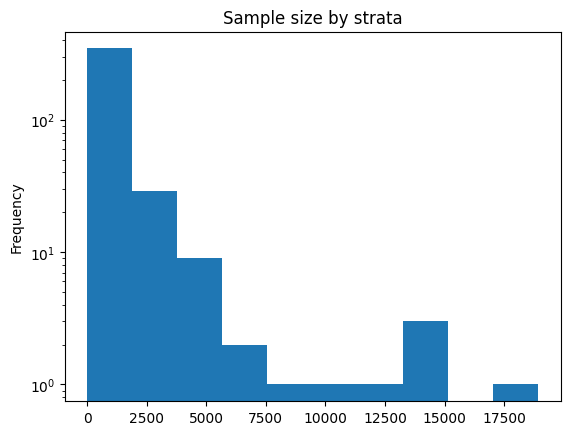

#### Using age_group/sex reference group(s)

299 strata already have n >= 30.

Strata with n < 30:

0
age_group sex    race_ethnicity       relationship                   
[0, 15)   Female AIAN                 Noninstitutionalized GQ pop  23
                 Asian                Institutionalized GQ pop     12
                                      Noninstitutionalized GQ pop   4
                 NHOPI                Institutionalized GQ pop      6
                                      Noninstitutionalized GQ pop  11
          Male   AIAN                 Noninstitutionalized GQ pop   6
                 Asian                Institutionalized GQ pop     22
                                      Noninstitutionalized GQ pop   0
                 NHOPI                Institutionalized GQ pop      5
                                      Noninstitutionalized GQ pop   1
...                                                                ..
[70, 80)  Male   NHOPI                Institutionalized GQ pop      6
                                      Noninstitutionalized GQ pop   3
[80, 100) Female AIAN                 Noninstitutionalized GQ pop   0
                 Multiracial or Other Noninstitutionalized GQ pop   3
                 NHOPI                Institutionalized GQ pop      9
                                      Noninstitutionalized GQ pop   5
          Male   AIAN                 Noninstitutionalized GQ pop   0
                 Multiracial or Other Noninstitutionalized GQ pop   3
                 NHOPI                Institutionalized GQ pop      3
                                      Noninstitutionalized GQ pop   0

[93 rows x 1 columns]

**Step 1:** Redistributing among small-sample-size relationships.

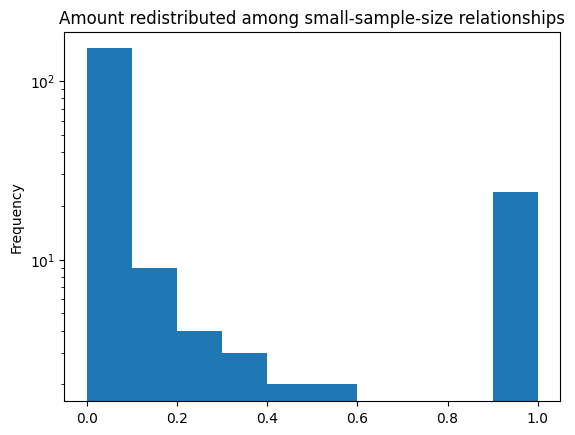

**Step 2:** Redistributing among all relationships.

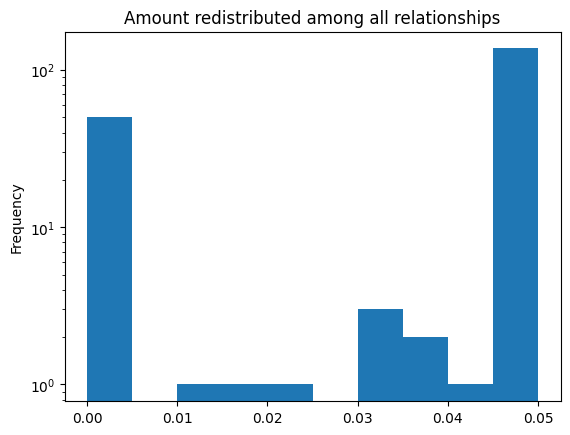

#### Using age_group reference group(s)

392 strata already have n >= 30.

No more smoothing required.

age_group  sex     race_ethnicity        relationship               
[0, 15)    Female  AIAN                  Institutionalized GQ pop       0.512871
                                         Noninstitutionalized GQ pop    0.487129
                   Asian                 Institutionalized GQ pop       0.536789
                                         Noninstitutionalized GQ pop    0.463211
                   Black                 Institutionalized GQ pop       0.371048
                                         Noninstitutionalized GQ pop    0.628952
                   Latino                Institutionalized GQ pop       0.491789
                                         Noninstitutionalized GQ pop    0.508211
                   Multiracial or Other  Institutionalized GQ pop       0.302317
                                         Noninstitutionalized GQ pop    0.697683
                                                                          ...   
[80, 100)  Male    Black                

In [72]:
gq_relationship_proportions, gq_sample_size = fill_proportions_by_sample_size(acs[acs.move_type == 'gq_person'], ['age_group', 'sex', 'race_ethnicity'], ['relationship'], min_stratification_columns=1)
gq_relationship_proportions

In [73]:
gq_sample_size.groupby(['age_group', 'sex', 'race_ethnicity']).sum().sort_values()

age_group  sex     race_ethnicity      
[50, 60)   Female  AIAN                       68
                   Asian                      79
[60, 70)   Female  Asian                      91
[0, 15)    Female  Multiracial or Other       99
[25, 30)   Female  AIAN                      113
[30, 40)   Female  Asian                     114
[18, 19)   Male    AIAN                      119
[60, 70)   Female  Multiracial or Other      122
[15, 18)   Female  Asian                     136
[60, 70)   Male    Asian                     158
                                           ...  
[80, 100)  Female  White                   13400
[22, 25)   Male    NHOPI                   13733
[18, 19)   Male    White                   14294
[19, 20)   Female  White                   14610
[30, 40)   Male    White                   14645
[19, 20)   Male    White                   14648
[80, 100)  Female  NHOPI                   15874
[25, 30)   Male    NHOPI                   19001
[18, 19)   Female  White     

In [74]:
len(gq_relationship_proportions[gq_relationship_proportions.isnull()])

0

In [75]:
len(gq_relationship_proportions[gq_relationship_proportions == np.inf])

0

In [76]:
len(gq_relationship_proportions[gq_relationship_proportions == 0])

0

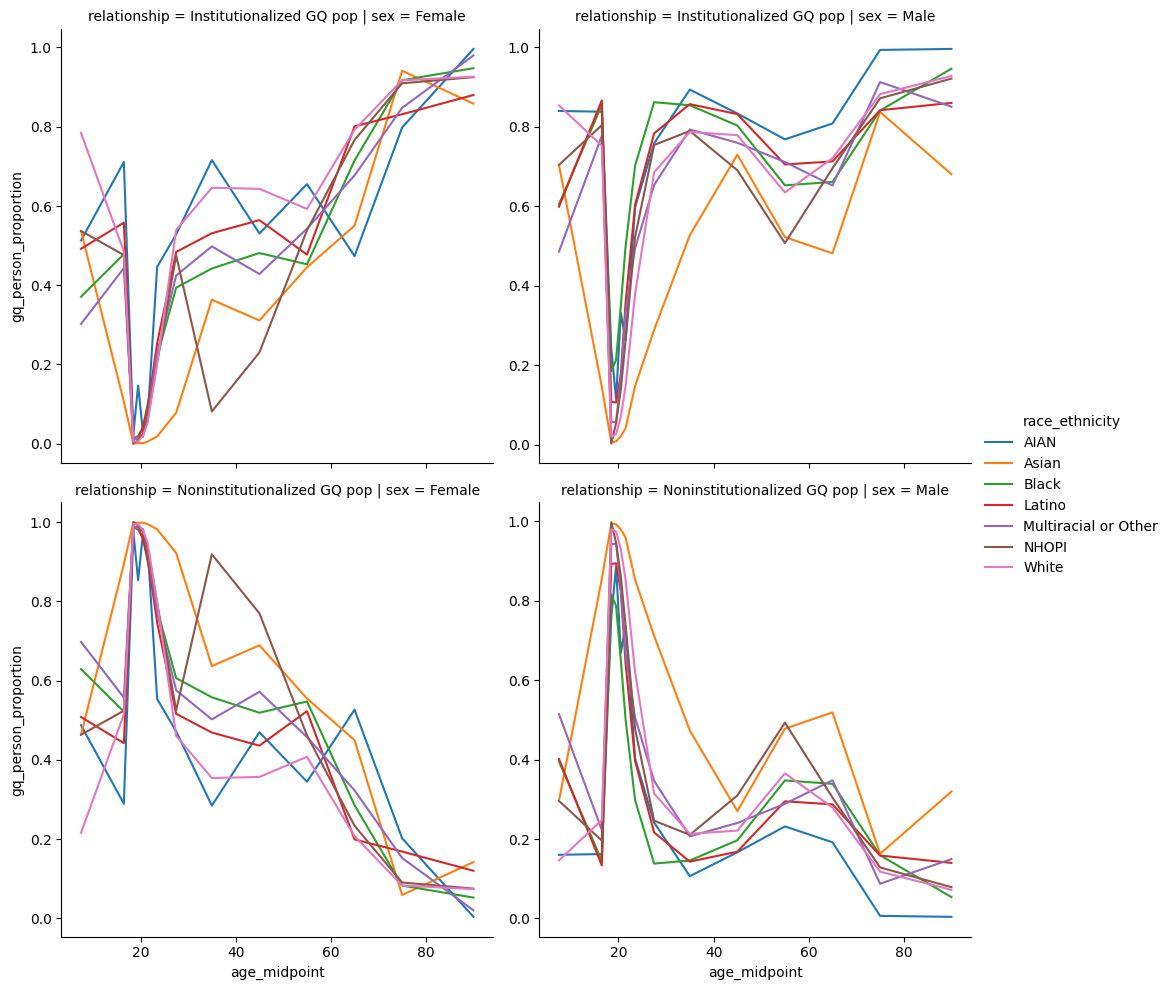

In [77]:
display_relationship_proportions(gq_relationship_proportions, 'gq_person_proportion')

In [78]:
format_relationship_proportions_for_file(gq_relationship_proportions, 'proportion').to_csv('sim_inputs/gq_person_move_relationship_proportions.csv', index=False, float_format='%f')

### Non-reference person relationship

In [79]:
# Relationships within households that moved as a unit
acs[acs.move_type == 'household'].groupby('relationship').PWGTP.sum().sort_values()

relationship
Foster child           16205
Child-in-law           39923
Parent-in-law          49937
Same-sex spouse        60812
Same-sex partner       64890
Adopted child         154954
Other relative        252486
Grandchild            269683
Parent                274521
Sibling               311578
Other nonrelative     387900
Stepchild             407967
Roommate              881921
Opp-sex partner      1254514
Opp-sex spouse       4423417
Biological child     7754638
Reference person     8399611
Name: PWGTP, dtype: int64

In [80]:
# GQ person mover relationship distribution
# This really surprises me! I would have expected way less institutionalized moving.
# This is a case where it might have a lot to do with the "where" part, i.e. distance.
acs[acs.move_type == 'gq_person'].groupby('relationship').PWGTP.sum().sort_values()

relationship
Institutionalized GQ pop       1545402
Noninstitutionalized GQ pop    1999399
Name: PWGTP, dtype: int64

In [81]:
# non-reference person mover relationship distribution
acs[acs.move_type == 'non_reference_person'].groupby('relationship').PWGTP.sum().sort_values()

relationship
Same-sex spouse        15736
Same-sex partner       40863
Adopted child          63257
Foster child           66238
Parent-in-law          88071
Child-in-law          198920
Stepchild             222725
Parent                236299
Sibling               321585
Opp-sex spouse        447649
Other relative        509204
Grandchild            676951
Opp-sex partner       739625
Other nonrelative     895649
Roommate             1306774
Biological child     1841344
Name: PWGTP, dtype: int64

<Axes: >

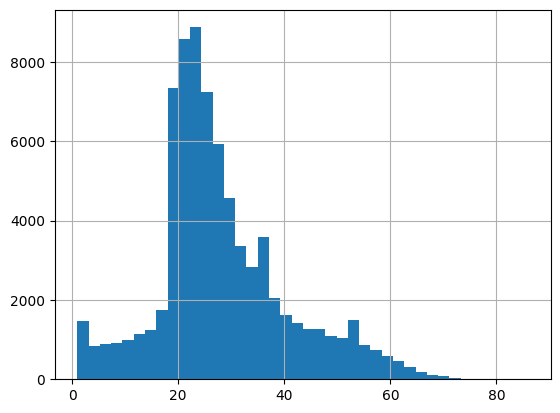

In [82]:
# Looking at the relationship between demographics and relationship in household for non-reference person movers -- specifically, age for biological children
acs[(acs.move_type == 'non_reference_person') & (acs.relationship == 'Biological child')].AGEP.hist(bins=40)

In [83]:
# An example household with a biological child mover -- we see here that they also brought their spouse, which we won't be able to capture (subfamily structure) unless it happens by astronomical luck
acs[acs.SERIALNO == acs[(acs.move_type == 'non_reference_person') & (acs.relationship == 'Biological child')].SERIALNO.sample(1, random_state=np.random.RandomState(1234)).iloc[0]]

SERIALNO  MIG  MIGSP  MIGPUMA  RELSHIPP  HISP  RAC1P  AGEP  SEX  \
1786233  2017001260783  1.0    NaN      NaN        20     1      1    57    2   
1786234  2017001260783  1.0    NaN      NaN        21     1      1    65    1   
1786235  2017001260783  3.0   48.0   5400.0        25     1      1    30    2   
1786236  2017001260783  NaN    NaN      NaN        30     1      1     0    1   
1786237  2017001260783  3.0   48.0   5400.0        32     1      1    29    1   

         ST  ...  PWGTP  race_ethnicity     sex age_group      relationship  \
1786233  48  ...     14           White  Female  [50, 60)  Reference person   
1786234  48  ...     14           White    Male  [60, 70)    Opp-sex spouse   
1786235  48  ...     21           White  Female  [30, 40)  Biological child   
1786236  48  ...     12           White    Male   [0, 15)        Grandchild   
1786237  48  ...     15           White    Male  [25, 30)      Child-in-law   

        domestic_migrant  gq_person  ref_person  MIGPUMA_ref_person  \
1786233              0.0      False        True                 NaN   
1786234              0.0      False       False                 NaN   
1786235              1.0      False       False                 NaN   
1786236              NaN      False       False                 NaN   
1786237              1.0      False       False                 NaN   

                    move_type  
1786233                  none  
1786234                  none  
1786235  non_reference_person  
1786236             undefined  
1786237  non_reference_person  

[5 rows x 21 columns]

### Smoothing 3,136 age_group/sex/race_ethnicity/relationship strata

Sample size by stratum:

0
age_group sex    race_ethnicity relationship          
[0, 15)   Female AIAN           Adopted child        4
                                Biological child    49
                                Child-in-law         0
                                Foster child        49
                                Grandchild         175
                                Opp-sex partner      0
                                Opp-sex spouse       0
                                Other nonrelative   30
                                Other relative      70
                                Parent               0
...                                                ...
[80, 100) Male   White          Opp-sex spouse     227
                                Other nonrelative  136
                                Other relative      95
                                Parent             569
                                Parent-in-law      285
                                Roommate            54
                                Same-sex partner     4
                                Same-sex spouse      5
                                Sibling             47
                                Stepchild            0

[3136 rows x 1 columns]

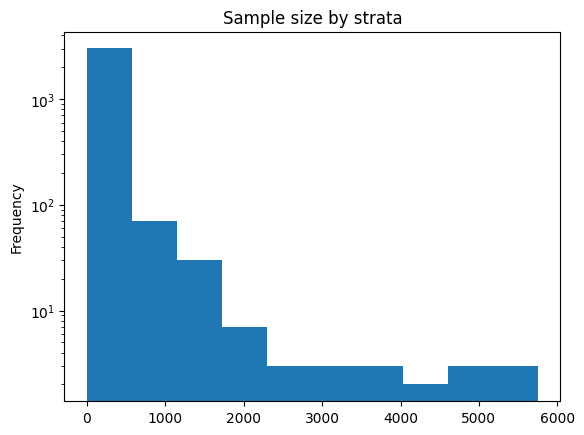

#### Using age_group/sex reference group(s)

961 strata already have n >= 30.

Strata with n < 30:

0
age_group sex    race_ethnicity relationship       
[0, 15)   Female AIAN           Adopted child     4
                                Child-in-law      0
                                Opp-sex partner   0
                                Opp-sex spouse    0
                                Parent            0
                                Parent-in-law     0
                                Roommate          0
                                Same-sex partner  0
                                Same-sex spouse   0
                                Sibling           1
...                                              ..
[80, 100) Male   NHOPI          Sibling           0
                                Stepchild         0
                 White          Adopted child     0
                                Biological child  0
                                Child-in-law      4
                                Foster child      0
                                Grandchild        0
                                Same-sex partner  4
                                Same-sex spouse   5
                                Stepchild         0

[2175 rows x 1 columns]

**Step 1:** Redistributing among small-sample-size relationships.

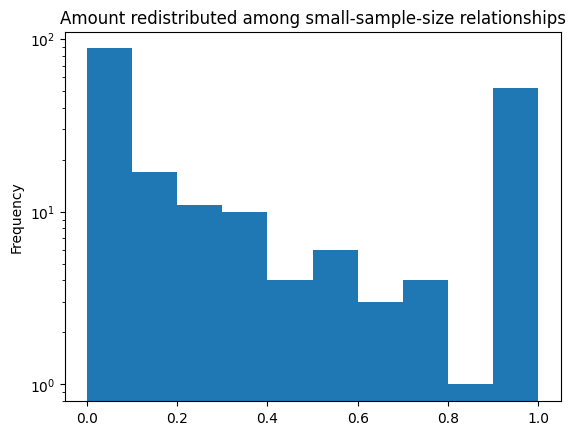

**Step 2:** Redistributing among all relationships.

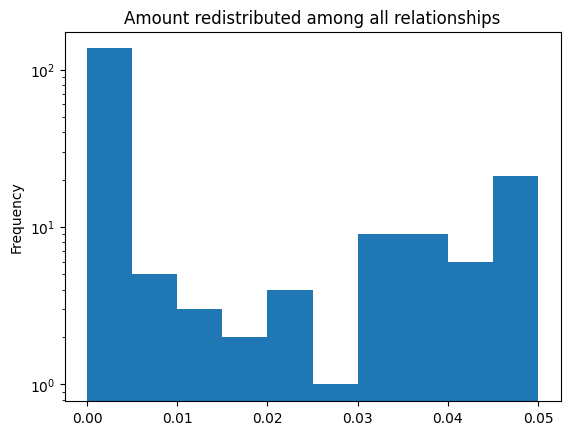

#### Using age_group reference group(s)

2,212 strata already have n >= 30.

Strata with n < 30:

0
age_group sex    race_ethnicity relationship       
[0, 15)   Female AIAN           Child-in-law      0
                                Opp-sex partner   0
                                Opp-sex spouse    0
                                Parent            0
                                Parent-in-law     0
                                Same-sex partner  0
                                Same-sex spouse   0
                 Asian          Child-in-law      0
                                Opp-sex partner   0
                                Opp-sex spouse    0
...                                              ..
[80, 100) Male   NHOPI          Same-sex spouse   5
                                Stepchild         0
                 White          Adopted child     0
                                Biological child  0
                                Child-in-law      4
                                Foster child      0
                                Grandchild        0
                                Same-sex partner  4
                                Same-sex spouse   5
                                Stepchild         0

[924 rows x 1 columns]

**Step 1:** Redistributing among small-sample-size relationships.

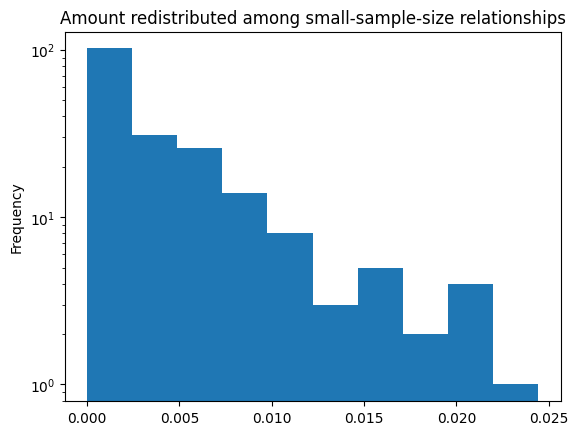

**Step 2:** Redistributing among all relationships.

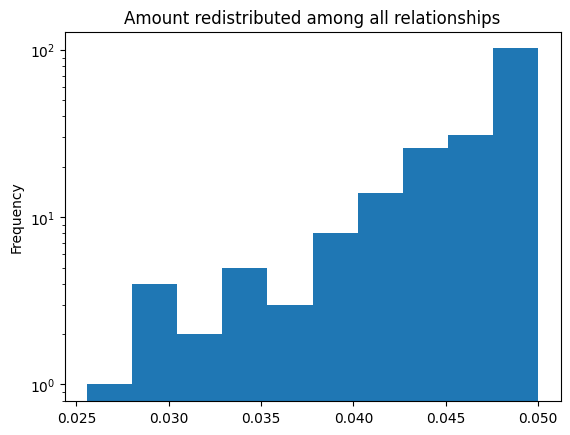

Reached minimum desired stratification.

age_group  sex     race_ethnicity  relationship     
[0, 15)    Female  AIAN            Adopted child        0.006823
                                   Biological child     0.167427
                                   Child-in-law         0.000000
                                   Foster child         0.097839
                                   Grandchild           0.410253
                                   Opp-sex partner      0.000000
                                   Opp-sex spouse       0.000000
                                   Other nonrelative    0.110244
                                   Other relative       0.153501
                                   Parent               0.000000
                                                          ...   
[80, 100)  Male    White           Opp-sex spouse       0.121390
                                   Other nonrelative    0.102970
                                   Other relative       0.057886
                                   Pa

In [84]:
nrp_relationship_proportions, nrp_sample_size = fill_proportions_by_sample_size(acs[acs.move_type == 'non_reference_person'], ['age_group', 'sex', 'race_ethnicity'], ['relationship'], min_stratification_columns=1)
nrp_relationship_proportions

In [85]:
nrp_sample_size.groupby(['age_group', 'sex', 'race_ethnicity']).sum().sort_values()

age_group  sex     race_ethnicity
[80, 100)  Male    Latino             1155
[15, 18)   Female  Black              1172
[21, 22)   Female  Latino             1222
[15, 18)   Female  Latino             1318
[18, 19)   Female  Latino             1343
[20, 21)   Female  Latino             1376
[60, 70)   Male    Latino             1395
[50, 60)   Female  Asian              1401
[80, 100)  Male    Asian              1446
                   Black              1455
                                     ...  
[25, 30)   Male    White             18474
           Female  AIAN              18601
[0, 15)    Female  NHOPI             20671
[22, 25)   Male    NHOPI             21197
[0, 15)    Male    NHOPI             21793
[30, 40)   Female  NHOPI             22007
[22, 25)   Female  NHOPI             22368
[25, 30)   Female  NHOPI             25935
[30, 40)   Male    NHOPI             26043
[25, 30)   Male    NHOPI             28170
Length: 196, dtype: int64

In [86]:
len(nrp_relationship_proportions[nrp_relationship_proportions.isnull()])

0

In [87]:
len(nrp_relationship_proportions[nrp_relationship_proportions == np.inf])

0

In [88]:
len(nrp_relationship_proportions[nrp_relationship_proportions == 0])

490

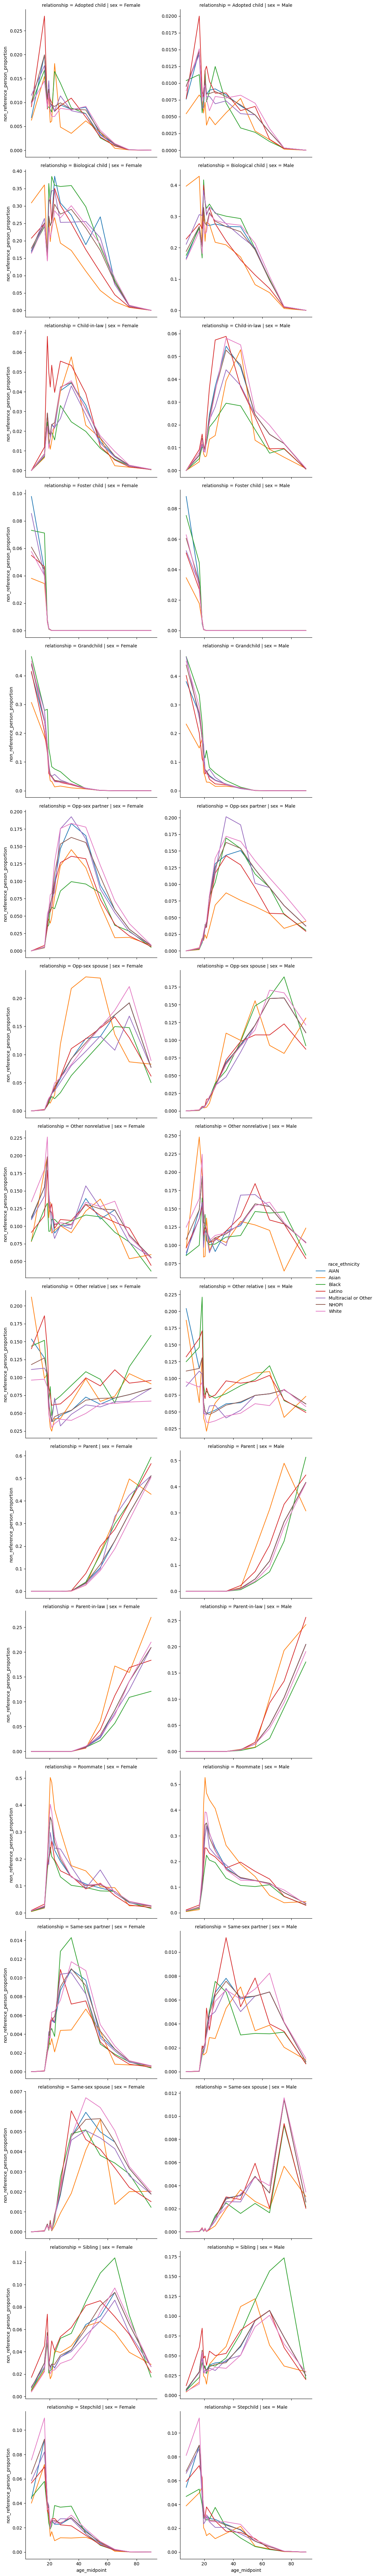

In [89]:
display_relationship_proportions(nrp_relationship_proportions, 'non_reference_person_proportion')

In [90]:
format_relationship_proportions_for_file(nrp_relationship_proportions, 'proportion').to_csv('sim_inputs/non_reference_person_move_relationship_proportions.csv', index=False, float_format='%f')

## Location -> location flows

<Axes: >

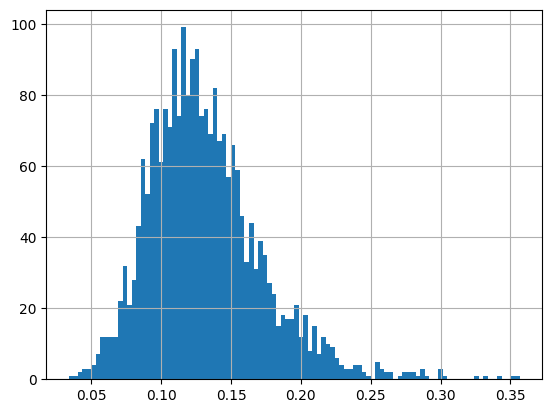

In [91]:
# Distribution of in-movers per capita by destination PUMA
(acs[acs.domestic_migrant == 1].groupby(['ST', 'PUMA']).PWGTP.sum() / acs[acs.domestic_migrant.notnull()].groupby(['ST', 'PUMA']).PWGTP.sum()).hist(bins=100)

In [92]:
# Look at high and low PUMAs to migrate to
(acs[acs.domestic_migrant == 1].groupby(['ST', 'PUMA']).PWGTP.sum() / acs[acs.domestic_migrant.notnull()].groupby(['ST', 'PUMA']).PWGTP.sum()).sort_values()

ST  PUMA 
6   3743     0.033763
36  3901     0.040044
6   3741     0.041064
36  4010     0.041731
    4008     0.043746
    4009     0.046304
    3208     0.046470
    3205     0.046873
    3204     0.048799
    3203     0.049598
               ...   
53  11603    0.290977
8   803      0.298982
26  2702     0.299831
48  501      0.300737
45  604      0.303878
4   207      0.325348
55  101      0.332578
49  49003    0.341479
12  7301     0.350565
39  4105     0.356542
Name: PWGTP, Length: 2351, dtype: float64

<Axes: xlabel='PWGTP_tot', ylabel='PWGTP_mig'>

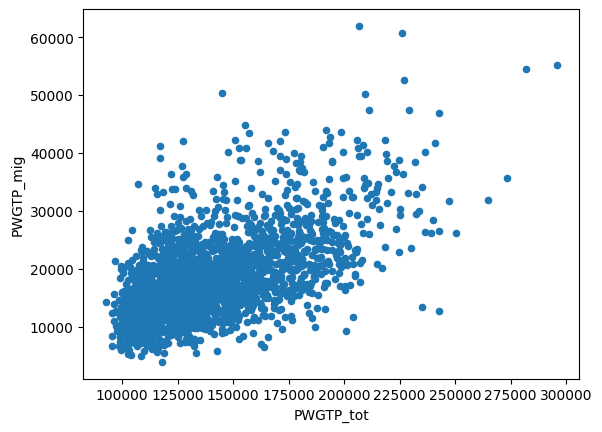

In [93]:
# Relationship between in-movers and population
pd.DataFrame(acs.groupby(['ST', 'PUMA']).PWGTP.sum()).join(acs[acs.domestic_migrant == 1].groupby(['ST', 'PUMA']).PWGTP.sum(), lsuffix='_tot', rsuffix='_mig').plot(kind='scatter', x='PWGTP_tot', y='PWGTP_mig')

In [94]:
# Looking at our sample size for informing where people move: specifically, how many people from each MIGPUMA
acs[acs.domestic_migrant == 1].groupby(['MIGSP', 'MIGPUMA']).size().sort_values()

MIGSP  MIGPUMA
48.0   6400.0       403
22.0   1600.0       406
54.0   900.0        407
22.0   1900.0       431
24.0   700.0        448
34.0   1700.0       451
13.0   2700.0       455
22.0   2100.0       477
54.0   1300.0       480
35.0   300.0        482
                  ...  
53.0   11600.0    16413
48.0   2300.0     16644
6.0    5900.0     17177
       7300.0     20510
48.0   4600.0     24495
8.0    190.0      26102
25.0   390.0      27032
4.0    100.0      27901
17.0   3400.0     28283
6.0    3700.0     49929
Length: 982, dtype: int64

### MIGPUMA -> PUMA flows

In [95]:
acs[acs.domestic_migrant == 1].groupby(['MIGSP', 'ST', 'PUMA']).size()

MIGSP  ST  PUMA 
1.0    1   100      885
           200      663
           301      600
           302      813
           400      543
           500      914
           600      625
           700      500
           800      603
           900      489
                   ... 
56.0   55  1400       1
           1600       1
           1601       4
           2400       2
           55102      3
       56  100      464
           200      448
           300      821
           400      506
           500      738
Length: 61388, dtype: int64

### Smoothing 2,308,682 MIGSP/MIGPUMA/ST/PUMA strata

Sample size by stratum:

0
dummy_column MIGSP MIGPUMA ST PUMA      
1            1.0   190.0   1  100    709
                              200     20
                              301      7
                              302     14
                              400      5
                              500     16
                              600     25
                              700     25
                              800      3
                              900      7
...                                  ...
             56.0  500.0   55 55102    0
                              55103    0
                              70101    0
                              70201    0
                              70301    0
                           56 100     21
                              200     33
                              300     29
                              400     21
                              500    646

[2308682 rows x 1 columns]

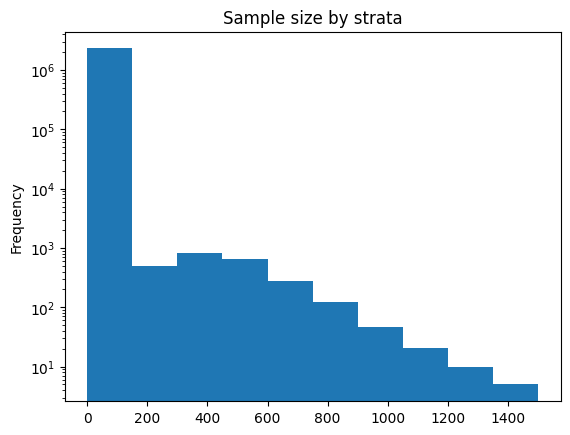

#### Using MIGSP reference group(s)

5,999 strata already have n >= 30.

Strata with n < 30:

0
dummy_column MIGSP MIGPUMA ST PUMA     
1            1.0   190.0   1  200    20
                              301     7
                              302    14
                              400     5
                              500    16
                              600    25
                              700    25
                              800     3
                              900     7
                              1000    9
...                                  ..
             56.0  500.0   55 50000   0
                              55101   0
                              55102   0
                              55103   0
                              70101   0
                              70201   0
                              70301   0
                           56 100    21
                              300    29
                              400    21

[2302683 rows x 1 columns]

**Step 1:** Redistributing among small-sample-size relationships.

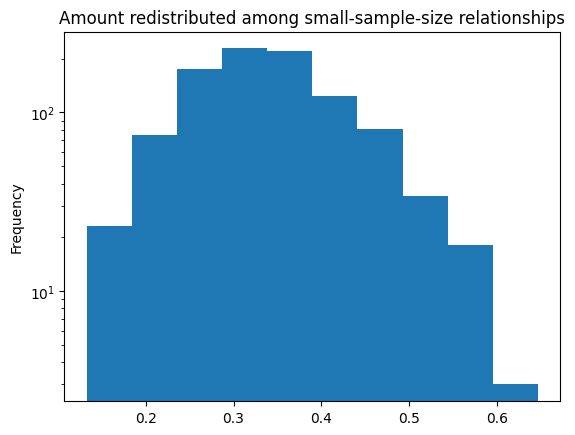

**Step 2:** Redistributing among all relationships.

No redistribution required in this step -- all groups already redistributed at least 5.0%.

#### Using the unconditional distribution reference group(s)

126,006 strata already have n >= 30.

Strata with n < 30:

0
dummy_column MIGSP MIGPUMA ST PUMA     
1            1.0   190.0   2  101     3
                              102     1
                              200     4
                              300    14
                              400     5
                           4  100     2
                              101     0
                              102     2
                              103     1
                              104     0
...                                  ..
             56.0  500.0   55 41003   0
                              41004   0
                              41005   0
                              50000   0
                              55101   0
                              55102   3
                              55103   0
                              70101   0
                              70201   0
                              70301   0

[2182676 rows x 1 columns]

**Step 1:** Redistributing among small-sample-size relationships.

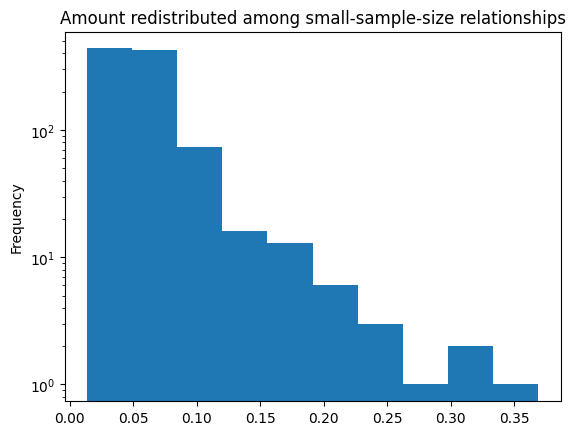

**Step 2:** Redistributing among all relationships.

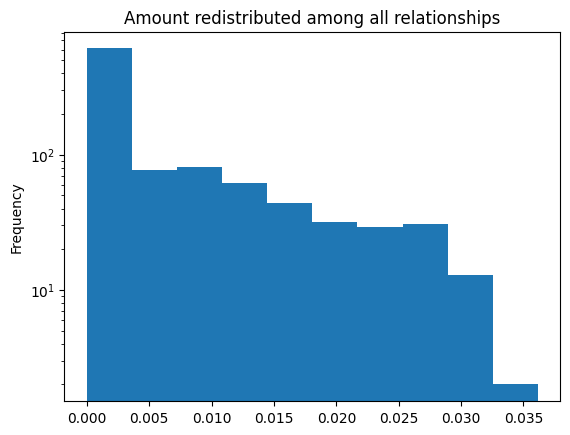

Reached minimum desired stratification.

CPU times: user 49.8 s, sys: 5.49 s, total: 55.3 s
Wall time: 54.6 s


MIGSP  MIGPUMA  ST  PUMA 
1.0    190.0    1   100      0.468848
                    200      0.009031
                    301      0.008931
                    302      0.008289
                    400      0.004208
                    500      0.005398
                    600      0.006580
                    700      0.004597
                    800      0.006724
                    900      0.005214
                               ...   
56.0   500.0    55  55102    0.000037
                    55103    0.000060
                    70101    0.000023
                    70201    0.000029
                    70301    0.000036
                56  100      0.037905
                    200      0.037008
                    300      0.075319
                    400      0.037143
                    500      0.717000
Name: PWGTP, Length: 2308682, dtype: float64

In [96]:
%%time

puma_proportions, puma_sample_size = fill_proportions_by_sample_size(
    acs[acs.domestic_migrant == 1],
    ['MIGSP', 'MIGPUMA'],
    ['ST', 'PUMA'],
    stratification_column_sets=[['MIGSP', 'MIGPUMA']],
    proportion_column_sets=[['ST', 'PUMA']],
)
puma_proportions

In [97]:
puma_sample_size.groupby(['MIGSP', 'MIGPUMA']).sum().sort_values()

MIGSP  MIGPUMA
6.0    3700.0     43828317
       5900.0     43869329
       100.0      43871335
       8500.0     43872442
       7300.0     43878057
       6500.0     43880428
       7100.0     43883202
       7500.0     43885099
       1300.0     43885242
       6700.0     43888074
                    ...   
50.0   200.0      58899098
       300.0      58899182
56.0   100.0      58899206
50.0   100.0      58899218
56.0   300.0      58899471
       500.0      58899565
2.0    100.0      58907102
       400.0      58907496
       300.0      58907507
       200.0      58907678
Length: 982, dtype: int64

In [98]:
len(puma_proportions[puma_proportions.isnull()])

0

In [99]:
len(puma_proportions[puma_proportions == np.inf])

0

In [100]:
len(puma_proportions[puma_proportions == 0])

0

### PUMA -> PUMA flows

Since MIGPUMA is the most granular we have about source, we simply repeat it for each corresponding source PUMA.

In [101]:
puma_to_migpuma = pd.read_hdf(f'{data_dir}/puma_to_migpuma.hdf', key='puma_to_migpuma')
puma_to_migpuma = (
    puma_to_migpuma[['MIGSP', 'MIGPUMA', 'ST', 'PUMA']]
        # Remove PR
        .pipe(lambda x: x[x.MIGSP != 72])
)
puma_to_migpuma

MIGSP  MIGPUMA  ST   PUMA
0         1      190   1    100
1         1      290   1    200
2         1      290   1    301
3         1      290   1    302
4         1      400   1    400
5         1      290   1    500
6         1      600   1    600
7         1      700   1    700
8         1      800   1    800
9         1      900   1    900
...     ...      ...  ..    ...
2341     55    55102  55  55102
2342     55    55100  55  55103
2343     55    70100  55  70101
2344     55    70100  55  70201
2345     55    70100  55  70301
2346     56      100  56    100
2347     56      200  56    200
2348     56      300  56    300
2349     56      400  56    400
2350     56      500  56    500

[2351 rows x 4 columns]

In [102]:
len(puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size())

982

In [103]:
puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size().value_counts()

1     655
2     118
3      60
4      41
5      20
6      19
7      18
8      11
9       6
10      6
13      4
11      3
14      3
16      3
22      2
15      2
18      2
38      2
12      2
26      1
25      1
69      1
35      1
34      1
dtype: int64

In [104]:
# Proportion of MIGPUMAs that are coterminous with a PUMA
puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size().value_counts().loc[1] / len(puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size())

0.6670061099796334

In [105]:
# Proportion of MIGPUMAs that have 1-2 PUMAs in them
puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size().value_counts().loc[[1, 2]].sum() / len(puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size())

0.7871690427698574

In [106]:
# Mean PUMAs per MIGPUMA
puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size().mean()

2.394093686354379

In [107]:
flows_by_source_puma = expand_index_to(
        puma_proportions.reset_index().rename(columns={'ST': 'destination_ST', 'PUMA': 'destination_PUMA'}).set_index(['MIGSP', 'MIGPUMA', 'destination_ST', 'destination_PUMA']),
        pd.MultiIndex.from_frame(puma_to_migpuma),
    full_match=False
)
flows_by_source_puma

destination_ST  destination_PUMA     PWGTP
MIGSP MIGPUMA ST PUMA                                            
1     190     1  100                1               100  0.468848
                 100                1               200  0.009031
                 100                1               301  0.008931
                 100                1               302  0.008289
                 100                1               400  0.004208
                 100                1               500  0.005398
                 100                1               600  0.006580
                 100                1               700  0.004597
                 100                1               800  0.006724
                 100                1               900  0.005214
...                               ...               ...       ...
56    500     56 500               55             55102  0.000037
                 500               55             55103  0.000060
                 500               55             70101  0.000023
                 500               55             70201  0.000029
                 500               55             70301  0.000036
                 500               56               100  0.037905
                 500               56               200  0.037008
                 500               56               300  0.075319
                 500               56               400  0.037143
                 500               56               500  0.717000

[5527201 rows x 3 columns]

In [108]:
flows_by_source_puma = (
    flows_by_source_puma
        .reset_index()
        .set_index(['ST', 'PUMA', 'destination_ST', 'destination_PUMA'])
        .PWGTP.rename('proportion')
        .sort_index()
)
flows_by_source_puma

ST  PUMA  destination_ST  destination_PUMA
1   100   1               100                 0.468848
                          200                 0.009031
                          301                 0.008931
                          302                 0.008289
                          400                 0.004208
                          500                 0.005398
                          600                 0.006580
                          700                 0.004597
                          800                 0.006724
                          900                 0.005214
                                                ...   
56  500   55              55102               0.000037
                          55103               0.000060
                          70101               0.000023
                          70201               0.000029
                          70301               0.000036
          56              100                 0.037905
                      

In [109]:
# This file came from https://gist.github.com/dantonnoriega/bf1acd2290e15b91e6710b6fd3be0a53
fips_to_name = pd.read_csv('us-state-ansi-fips.csv')
fips_to_name.columns = [c.strip() for c in fips_to_name.columns]
fips_to_name = fips_to_name.rename(columns={'st': 'destination_ST', 'stusps': 'destination_ST_name'})

In [110]:
flows_with_names = pd.DataFrame(flows_by_source_puma).reset_index().merge(fips_to_name, on='destination_ST').set_index(['ST', 'PUMA', 'destination_ST_name', 'destination_PUMA']).sort_index().proportion

In [111]:
# TODO: Would be nice to map these, but it's unfortunately hard to do that with only gbd_env packages.
# Sticking with this for now to save the headache of creating a custom env.

# Destinations from downtown Seattle (very small PUMA).
flows_with_names.loc[(53, 11603)].sort_values()

destination_ST_name  destination_PUMA
 CA                  3743                0.000008
 NY                  3208                0.000011
                     3203                0.000011
                     3209                0.000011
                     4010                0.000012
                     3205                0.000012
                     3204                0.000012
 CA                  3741                0.000012
                     3716                0.000013
 NY                  3210                0.000013
                                           ...   
 WA                  11605               0.038360
                     11613               0.038384
                     11610               0.040408
                     11607               0.040841
                     11612               0.042024
                     11608               0.044048
                     11604               0.044258
                     11602               0.054049
            

In [112]:
# Destination states from downtown Seattle.
flows_with_names.loc[(53, 11603)].groupby('destination_ST_name').sum().sort_values()

destination_ST_name
 VT    0.000165
 WY    0.000205
 DE    0.000237
 RI    0.000251
 DC    0.000253
 ND    0.000271
 SD    0.000276
 ME    0.000362
 NH    0.000377
 AK    0.000397
 WV    0.000431
 NM    0.000564
 NE    0.000615
 MS    0.000780
 CT    0.000837
 AR    0.000919
 IA    0.000929
 KS    0.000960
 HI    0.001010
 NV    0.001057
 UT    0.001141
 LA    0.001213
 AL    0.001341
 OK    0.001347
 KY    0.001348
 SC    0.001434
 MN    0.001566
 MD    0.001577
 WI    0.001640
 MA    0.001689
 NJ    0.001808
 MO    0.001821
 IN    0.001949
 MT    0.001950
 TN    0.002001
 CO    0.002051
 VA    0.002515
 MI    0.002744
 NC    0.003082
 PA    0.003203
 IL    0.003234
 GA    0.003324
 OH    0.003377
 AZ    0.003862
 NY    0.003990
 ID    0.005005
 FL    0.006305
 TX    0.008699
 OR    0.009765
 CA    0.011136
 WA    0.892987
Name: proportion, dtype: float64

In [113]:
# Destinations from Clallam & Jefferson Counties (very large rural PUMA).
# We see much higher affinity to remain in the same PUMA, which makes sense.
flows_with_names.loc[(53, 11900)].sort_values()

destination_ST_name  destination_PUMA
 CA                  3743                0.000006
 NY                  3208                0.000007
                     3203                0.000007
                     3209                0.000008
                     4010                0.000008
                     3205                0.000008
                     3204                0.000008
 CA                  3741                0.000008
                     3716                0.000008
 NY                  3210                0.000009
                                           ...   
 WA                  10501               0.007740
                     10502               0.008119
                     10800               0.008334
                     11601               0.008703
                     11602               0.008972
                     10200               0.009412
                     11401               0.010182
                     11603               0.010214
            

In [114]:
# Destination states from Clallam & Jefferson Counties.
flows_with_names.loc[(53, 11900)].groupby('destination_ST_name').sum().sort_values()

destination_ST_name
 VT    0.000111
 WY    0.000137
 DE    0.000158
 RI    0.000168
 DC    0.000169
 ND    0.000182
 SD    0.000184
 ME    0.000242
 NH    0.000252
 AK    0.000266
 WV    0.000289
 NM    0.000377
 NE    0.000411
 MS    0.000522
 CT    0.000560
 AR    0.000615
 IA    0.000621
 KS    0.000642
 HI    0.000676
 NV    0.000707
 UT    0.000763
 LA    0.000812
 AL    0.000897
 OK    0.000901
 KY    0.000902
 SC    0.000960
 MN    0.001047
 MD    0.001055
 WI    0.001097
 MA    0.001130
 NJ    0.001210
 MO    0.001219
 IN    0.001304
 MT    0.001304
 TN    0.001339
 CO    0.001372
 VA    0.001683
 MI    0.001836
 NC    0.002062
 PA    0.002143
 IL    0.002164
 GA    0.002224
 OH    0.002259
 AZ    0.002584
 NY    0.002669
 ID    0.003349
 FL    0.004218
 TX    0.005820
 OR    0.006533
 CA    0.007160
 WA    0.928695
Name: proportion, dtype: float64

In [115]:
# Destinations from suburban PUMA outside Baltimore.
flows_with_names.loc[(24, 502)].sort_values()

destination_ST_name  destination_PUMA
 CA                  3743                0.000006
 NY                  3208                0.000008
                     3203                0.000008
                     3209                0.000008
                     4010                0.000008
                     3205                0.000008
                     3204                0.000009
 CA                  3741                0.000009
                     3716                0.000009
 NY                  3210                0.000009
                                           ...   
 MD                  804                 0.025854
                     801                 0.034650
                     803                 0.035290
                     501                 0.063150
                     507                 0.063609
                     506                 0.066278
                     505                 0.074711
                     503                 0.079781
            

In [116]:
# Destination states from suburban PUMA outside Baltimore.
flows_with_names.loc[(24, 502)].groupby('destination_ST_name').sum().sort_values()

destination_ST_name
 VT    0.000118
 WY    0.000146
 AK    0.000172
 RI    0.000179
 ND    0.000194
 SD    0.000197
 MT    0.000246
 ME    0.000258
 HI    0.000265
 NH    0.000269
 NM    0.000402
 ID    0.000431
 NE    0.000439
 MS    0.000557
 CT    0.000598
 AR    0.000656
 IA    0.000663
 KS    0.000686
 UT    0.000737
 NV    0.000755
 LA    0.000866
 AL    0.000957
 OK    0.000962
 KY    0.000963
 OR    0.001012
 MN    0.001118
 WI    0.001171
 NJ    0.001291
 MO    0.001301
 MA    0.001370
 SC    0.001385
 IN    0.001392
 TN    0.001429
 CO    0.001465
 AZ    0.001755
 WA    0.001838
 MI    0.001960
 NC    0.002201
 GA    0.002209
 WV    0.002283
 IL    0.002310
 OH    0.002412
 NY    0.002849
 DE    0.003086
 PA    0.004722
 FL    0.004878
 DC    0.006101
 TX    0.006213
 CA    0.006912
 VA    0.006974
 MD    0.916643
Name: proportion, dtype: float64

In [117]:
# Unsurprisingly, the *least* moved to PUMAs are basically the same no matter the source PUMA.
# That's because these should essentially always be filled by the same unconditional distribution.
# Among the least: East LA, Nassau County NY, parts of Brooklyn NY.
# These seem counter-intuitive but they are some of the least-moved-to according to ACS!
(acs[acs.domestic_migrant == 1].groupby(['ST', 'PUMA']).PWGTP.sum() / acs.groupby(['ST', 'PUMA']).PWGTP.sum()).sort_values()

ST  PUMA 
6   3743     0.033403
36  3901     0.039678
6   3741     0.040582
36  4010     0.041274
    4008     0.043069
    4009     0.045791
    3208     0.046014
    3205     0.046537
    3204     0.048416
    3203     0.049169
               ...   
53  11603    0.288684
48  501      0.296081
8   803      0.297175
26  2702     0.297401
45  604      0.299595
4   207      0.322796
55  101      0.330082
49  49003    0.335035
12  7301     0.347154
39  4105     0.352791
Name: PWGTP, Length: 2351, dtype: float64

In [118]:
def format_puma_to_puma_flows_for_file(puma_to_puma_flows, name):
    if isinstance(puma_to_puma_flows, pd.Series):
        puma_to_puma_flows = puma_to_puma_flows.rename(name).reset_index()
    else:
        puma_to_puma_flows = puma_to_puma_flows.reset_index()
    return puma_to_puma_flows.rename(columns={'ST': 'state', 'PUMA': 'puma', 'destination_ST': 'destination_state', 'destination_PUMA': 'destination_puma'})

In [119]:
format_puma_to_puma_flows_for_file(flows_by_source_puma, 'proportion')

state  puma  destination_state  destination_puma  proportion
0            1   100                  1               100    0.468848
1            1   100                  1               200    0.009031
2            1   100                  1               301    0.008931
3            1   100                  1               302    0.008289
4            1   100                  1               400    0.004208
5            1   100                  1               500    0.005398
6            1   100                  1               600    0.006580
7            1   100                  1               700    0.004597
8            1   100                  1               800    0.006724
9            1   100                  1               900    0.005214
...        ...   ...                ...               ...         ...
5527191     56   500                 55             55102    0.000037
5527192     56   500                 55             55103    0.000060
5527193     56   500                 55             70101    0.000023
5527194     56   500                 55             70201    0.000029
5527195     56   500                 55             70301    0.000036
5527196     56   500                 56               100    0.037905
5527197     56   500                 56               200    0.037008
5527198     56   500                 56               300    0.075319
5527199     56   500                 56               400    0.037143
5527200     56   500                 56               500    0.717000

[5527201 rows x 5 columns]

In [ ]:
format_puma_to_puma_flows_for_file(flows_by_source_puma, 'proportion').to_csv('/mnt/team/simulation_science/priv/users/zmbc/prl/puma_to_puma_proportions.csv', index=False, float_format='%.10f')